# Roy Curechean - BSc Computer Science - Data Science Workshop Final Project

My name is Roy Curechean, and I am a 26-year-old BSc Computer Science student at The Open University of Israel. Additionally, I hold the position of Associate Product Manager at Bitpanda, a prominent cryptocurrency and financial assets brokerage firm in Europe. As part of my responsibilities at Bitpanda, I oversee all cryptocurrency and security listings on our platform, as well as managing some of our hedging operations and algorithms. I am a passionate cryptocurrency enthusiast and have actively engaged with the crypto community for the past three years. My involvement extends to areas like DeFi, NFTs, trading, and various on-chain activities. I strongly believe that the world of cryptocurrencies will revolutionize the finance sector in the years to come, transferring financial control from banks, institutions, and governments to the people.

In this project, I will build various machine learning models to predict the movements of certain cryptocurrencies. In traditional finance, such models are common, with large firms specializing in High-Frequency Trading (HFT). They construct highly intricate models trained on many features not readily available to the general public. However, the cryptocurrency world operates under different rules. Since most blockchains (including those we'll analyze in this project) are public ledgers, any user can access and track fund movements, token trading, and wallet holdings on the blockchain. This accessibility levels the playing field for individuals against massive corporations that employ supercomputers and advanced algorithms for trading.

For this project, we will gather data from both the blockchain and centralized exchanges, primarily Binance, to delve into the worlds of cryptocurrencies, machine learning, and trading. Our aim is to explore how we can amalgamate these three domains to construct a model that outperforms the market, or at the very least, surpasses the performance of the majority of participants in the market.

Dependencies:

In [1]:
pip install ccxt requests pandas numpy scikit-learn keras pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.6 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.9/390.9 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.7/274.7 kB 22.4 MB/s eta 0:00:00
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218908 sha256=27762ee61836890f1b8ca97840ad590f63970f0e608fd4c91474adc1b463b969
  Stored in directory: /Users/roy.curechean/Library/Caches/pip/wheels/7f/33/8b/50b245c5c65433cd8f5cb24ac15d97e5a3db2d41a8b6ae957d
Successfully built pandas_ta
Note: you may need to restart the kernel to use updated packages.


# EDA

To get the Pricing data I will be using the `ccxt` library:

`ccxt` (CryptoCurrency eXchange Trading Library) is an open-source Python library that provides a unified interface for interacting with a wide range of cryptocurrency exchange APIs. It allows developers to access market data, execute trades, and manage accounts on various cryptocurrency exchanges through a single, consistent API.

After getting the initial pricing data, i'll plot it and try to observe any connections between the different features, to try and identify the best features for my model. I'll also add Techincal Analysis Features and Market Sentiment Features.

In [2]:
import ccxt
import datetime
import pandas as pd
import numpy as np

exchange = ccxt.binance()
symbol = 'ETH/USDT'  # Ethereum to USDT (Tether)
timeframe = '1d'     # Daily interval
start_date = pd.Timestamp('2017-08-17T00:00:00Z', tz='UTC')
end_date = pd.Timestamp.now(tz='UTC')
all_ohlcv = []
limit = 1000
current_start_date = start_date

# Fetch historical OHLCV (Open, High, Low, Close, Volume) data in chunks
while current_start_date < end_date:
    ohlcv = exchange.fetch_ohlcv(symbol, timeframe, exchange.parse8601(str(current_start_date)), limit=limit)
    all_ohlcv.extend(ohlcv)
    # Update the current start date for the next request
    current_start_date = pd.to_datetime(ohlcv[-1][0], unit='ms', utc=True) + pd.Timedelta(days=1)

# Create a DataFrame from the list of OHLCV data
df = pd.DataFrame(all_ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms', utc=True)
df = df[(df['timestamp'] >= start_date) & (df['timestamp'] <= end_date)]


df['timestamp'] = df['timestamp'].dt.strftime('%Y-%m-%d')


# add a new column with the close price of the next day
df["next_day"] = df["close"].shift(-1)
# Create the "target" column based on conditions
df['target'] = np.where(df["next_day"] > df["close"], 1, 0)

# save the today row to append after collecting all features
today_df = df.tail(1)

df


,timestamp,open,high,low,close,volume,next_day,target
0,2017-08-17,301.13,312.18,298.00,302.00,7030.71034,293.96,0
1,2017-08-18,302.00,311.79,283.94,293.96,9537.84646,290.91,0
2,2017-08-19,293.31,299.90,278.00,290.91,2146.19773,299.10,1
3,2017-08-20,289.41,300.53,282.85,299.10,2510.13871,323.29,1
4,2017-08-21,299.10,346.52,294.60,323.29,5219.44542,309.80,0
...,...,...,...,...,...,...,...,...
2423,2024-04-05,3327.39,3350.00,3210.00,3317.85,344556.79830,3351.59,1
2424,2024-04-06,3317.85,3398.42,3306.68,3351.59,183312.21250,3454.20,1
2425,2024-04-07,3351.59,3459.94,3344.08,3454.20,210459.07520,3694.61,1
2426,2024-04-08,3454.20,3730.71,3406.36,3694.61,496841.35320,3520.98,0


Now that we have got our initial data - let's present it in with mathplotlib; we will plot the price chart (by the close value) and the volume:

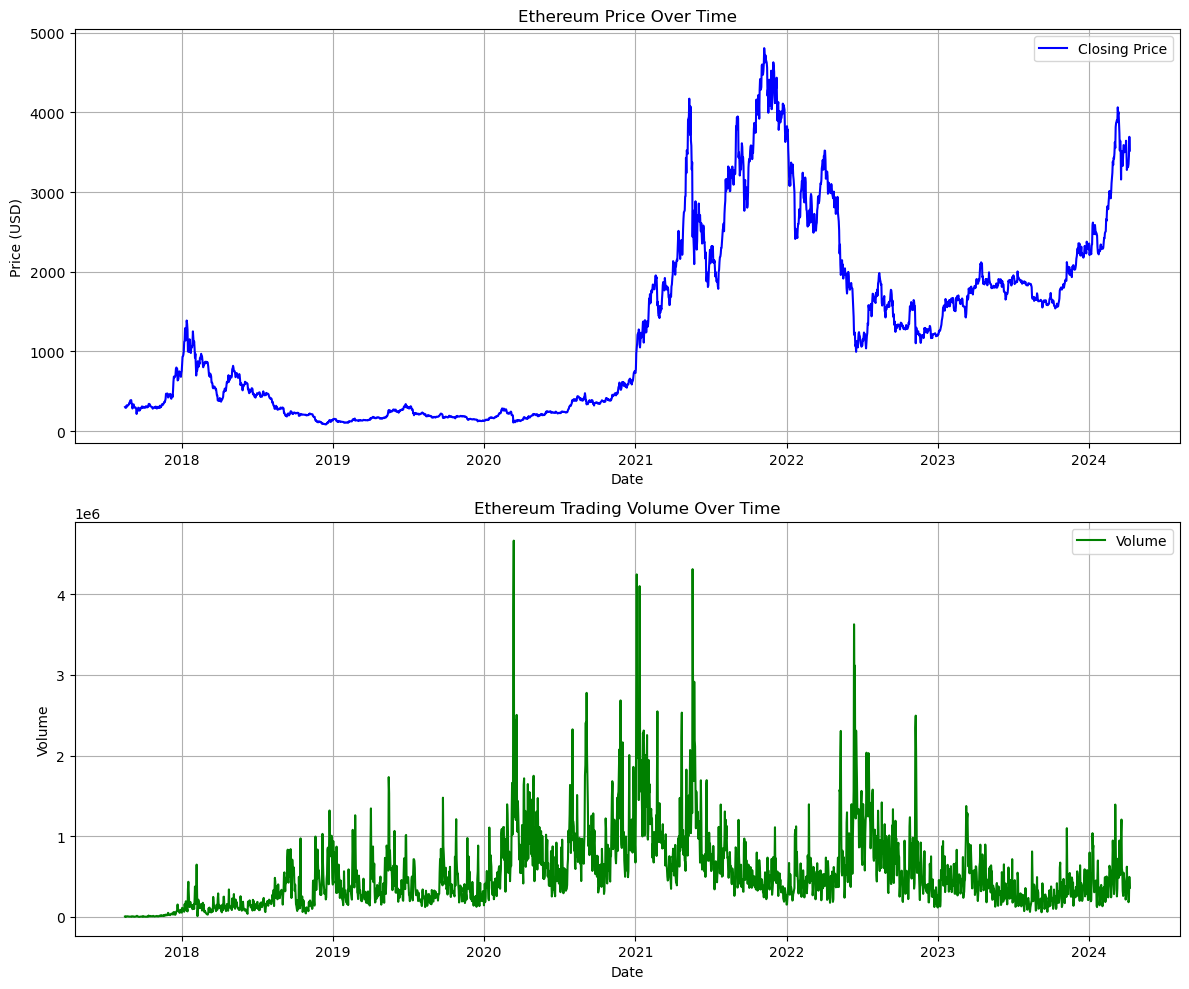

In [3]:
import matplotlib.pyplot as plt
from datetime import datetime

def plot_ohlcv(df):
    date_objects = [datetime.strptime(timestamp, "%Y-%m-%d") for timestamp in df['timestamp']]

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # Plot the historical Ethereum closing prices
    ax1.plot(date_objects, df['close'], label='Closing Price', color='blue')
    ax1.set_title('Ethereum Price Over Time')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price (USD)')
    ax1.legend()
    ax1.grid(True)

    # Plot the historical Ethereum volume
    ax2.plot(date_objects, df['volume'], label='Volume', color='green')
    ax2.set_title('Ethereum Trading Volume Over Time')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Volume')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()  # Automatically adjust subplot parameters for a clean layout
    plt.show()

plot_ohlcv(df)

These two charts provide us a very good visual exploration of Ethereum's (ETH) price and trading volume over time.

From the first chart, we can observe the closing price of Ethereum fluctuates significantly over the years, with noticeable peaks and troughs. A significant spike in price can be seen around early 2018 and mid-2021, which then subsequently corrects to lower levels. The overall trend suggests that Ethereum's price is highly volatile, with periods of rapid increase followed by declines.

The second chart illustrates the trading volume of ETH/USD over the same period. Trading volume appears to have several spikes that coincide with large price movements, particularly the peaks in 2018 and 2021. This suggests that trading activity increases significantly during market highs and lows, which is common in financial markets as traders and investors react to price changes.

The relationship between price and volume can often be indicative of market sentiment. For example, high volume during price increases may signal strong buyer interest, suggesting a bullish outlook. Conversely, if volume spikes during a price decline, it may indicate a sell-off. However, it is important to note that volume alone does not necessarily dictate price direction; it can only provide clues about the strength or weakness of a market trend.

In general we can see some correlation between the 2 charts which indicates that the volume might act as a good feature for our model to try and predict the price movement

# Rolling Window Features

To refine the predictive capabilities of our algorithm, i'll introduce a broader perspective by considering historical price data over various time horizons. By comparing current prices to past averages and identifying prevailing trends, we can craft a more nuanced and data-rich foundation for our predictions.

Let’s dive into the implementation of this approach:

- Horizons: We define a series of timeframes—spanning from 2 to 365 days—each representing a different 'look-back' period to analyze past price movements.

- New Predictors:

    - Ratio: For each horizon, we calculate the 'ratio' predictor as the current closing price divided by the average closing price over that horizon. This ratio will reflect how the current price stands relative to historical averages.
    - Trend: The 'trend' predictor sums the number of days within the horizon that the market closed higher versus lower, providing a net score of the recent market direction.


In [4]:
import numpy as np

horizons = [7, 14, 30, 60, 180]
features = []

# Select only the numeric columns (excluding "timestamp")
numeric_cols = df.select_dtypes(include=[np.number])

for horizon in horizons:
    rolling_avregaes = numeric_cols.rolling(horizon).mean()
    
    ratio_col = f"close_ratio_{horizon}"
    df[ratio_col] = df["close"] / rolling_avregaes["close"]
    
    trend_col = f"trend_{horizon}"
    df[trend_col] = df["target"].shift(1).rolling(horizon).sum()
    
    
    # add the new predictors
    features += [ratio_col, trend_col]
    
# keep volume as perdictor
#features += ['volume']
    
# drop rows with NaN
#df = df.dropna()
#show df
df

,timestamp,open,high,low,close,volume,next_day,target,close_ratio_7,trend_7,close_ratio_14,trend_14,close_ratio_30,trend_30,close_ratio_60,trend_60,close_ratio_180,trend_180
0,2017-08-17,301.13,312.18,298.00,302.00,7030.71034,293.96,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-08-18,302.00,311.79,283.94,293.96,9537.84646,290.91,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-08-19,293.31,299.90,278.00,290.91,2146.19773,299.10,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-08-20,289.41,300.53,282.85,299.10,2510.13871,323.29,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-08-21,299.10,346.52,294.60,323.29,5219.44542,309.80,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2423,2024-04-05,3327.39,3350.00,3210.00,3317.85,344556.79830,3351.59,1,0.972171,3.0,0.959244,6.0,0.923118,13.0,1.008908,34.0,1.325876,102.0
2424,2024-04-06,3317.85,3398.42,3306.68,3351.59,183312.21250,3454.20,1,0.988431,4.0,0.968557,7.0,0.937000,13.0,1.014136,34.0,1.334112,103.0
2425,2024-04-07,3351.59,3459.94,3344.08,3454.20,210459.07520,3694.61,1,1.026960,4.0,0.998226,7.0,0.969564,13.0,1.039788,34.0,1.369244,104.0
2426,2024-04-08,3454.20,3730.71,3406.36,3694.61,496841.35320,3520.98,0,1.089606,5.0,1.065411,7.0,1.039092,13.0,1.105087,35.0,1.457712,105.0


## Sentiment - Fear and Greed Index
The cryptocurrency market, known for its high volatility, is often swayed by shifts in sentiment and breaking news. To construct a reliable model, incorporating some form of sentiment analysis is key. To capture this aspect, I’ve opted to integrate the "fear and greed index" into our dataset. This index is designed to gauge the prevailing sentiment in the crypto market, ranging from extreme greed to extreme fear, based on various factors like volatility, market momentum, social media, dominance, and trends. The index takes into consideration many factors:

- Volatility (25 %)
- Market Momentum/Volume (25%)
- Social Media (15%)
- Dominance (10%)
- Trends (10%)

You can read more about the Fear and Greed Index here: `https://alternative.me/crypto/fear-and-greed-index/`
We will use the Fear and Greed Index API to fetch the fear and greed data in the past few years and we'll add it to our dataset to then use as a feature in our model.

In [5]:
import requests
import pandas as pd

api_url = "https://api.alternative.me/fng/"

# Define the parameters to request all available data
params = {
    "limit": 0,  # Retrieve all available data
    "format": "json",
}

response = requests.get(api_url, params=params)
if response.status_code == 200:
    # Parse the JSON response
    data = response.json()
    fng_data = data.get("data", [])
    fear_greed_df = pd.DataFrame(fng_data)
    
    # Convert the "timestamp" column to a datetime format
    fear_greed_df['timestamp'] = pd.to_datetime(fear_greed_df['timestamp'], unit='s')
    
    fear_greed_df.reset_index(drop=True, inplace=True)   
    fear_greed_df
else:
    print(f"Failed to retrieve data. Status code: {response.status_code}")

# clean up fethced data    
del fear_greed_df['value_classification']
del fear_greed_df['time_until_update']
fear_greed_df = fear_greed_df.rename(columns = {'value': 'fear_greed_value'}, inplace=False)
fear_greed_df['fear_greed_value'] = fear_greed_df['fear_greed_value'].astype(int)
fear_greed_df

/var/folders/k1/8wbtg9fj7zj7fpd7_kjz03jm0000gn/T/ipykernel_4129/198319697.py:20: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  fear_greed_df['timestamp'] = pd.to_datetime(fear_greed_df['timestamp'], unit='s')


,fear_greed_value,timestamp
0,80,2024-04-09
1,76,2024-04-08
2,78,2024-04-07
3,75,2024-04-06
4,79,2024-04-05
...,...,...
2252,11,2018-02-05
2253,24,2018-02-04
2254,40,2018-02-03
2255,15,2018-02-02


Let's merge this into our main dataframe:

In [6]:
fear_greed_df['timestamp'] = pd.to_datetime(fear_greed_df['timestamp'])
df['timestamp'] = pd.to_datetime(df['timestamp'])


df = df.merge(fear_greed_df[['timestamp', 'fear_greed_value']], on='timestamp', how='left')

features.append('fear_greed_value')

df

,timestamp,open,high,low,close,volume,next_day,target,close_ratio_7,trend_7,close_ratio_14,trend_14,close_ratio_30,trend_30,close_ratio_60,trend_60,close_ratio_180,trend_180,fear_greed_value
0,2017-08-17,301.13,312.18,298.00,302.00,7030.71034,293.96,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-08-18,302.00,311.79,283.94,293.96,9537.84646,290.91,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-08-19,293.31,299.90,278.00,290.91,2146.19773,299.10,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-08-20,289.41,300.53,282.85,299.10,2510.13871,323.29,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-08-21,299.10,346.52,294.60,323.29,5219.44542,309.80,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2423,2024-04-05,3327.39,3350.00,3210.00,3317.85,344556.79830,3351.59,1,0.972171,3.0,0.959244,6.0,0.923118,13.0,1.008908,34.0,1.325876,102.0,79.0
2424,2024-04-06,3317.85,3398.42,3306.68,3351.59,183312.21250,3454.20,1,0.988431,4.0,0.968557,7.0,0.937000,13.0,1.014136,34.0,1.334112,103.0,75.0
2425,2024-04-07,3351.59,3459.94,3344.08,3454.20,210459.07520,3694.61,1,1.026960,4.0,0.998226,7.0,0.969564,13.0,1.039788,34.0,1.369244,104.0,78.0
2426,2024-04-08,3454.20,3730.71,3406.36,3694.61,496841.35320,3520.98,0,1.089606,5.0,1.065411,7.0,1.039092,13.0,1.105087,35.0,1.457712,105.0,76.0


### Additional Predictors: Bitcoin's Relative Price Impact

Given Bitcoin's substantial market capitalization and widespread adoption, it stands as a pivotal factor in the broader cryptocurrency landscape. To capture this influence, we propose adding Bitcoin's price dynamics as a potential predictor in our model to see if it can provide us with more nuanced insights.

The goal is not to overload the model with an excessive number of Bitcoin-related features but to select a singular, impactful predictor. To this end, we hypothesize that the ETH/BTC price ratio might serve as an informative indicator, reflecting Bitcoin's performance relative to Ethereum.

We'll use ccxt again to get the BTC price. We'll then clean the data and merge the price of BTC with our current df. We don't want to use too many features of BTC to predict Ethereum price, therefore we need to think what will be the best predictor to add.

let's give it a try:

In [7]:
import ccxt
import datetime
import pandas as pd
import datetime


exchange = ccxt.binance()
symbol = 'ETH/BTC'  # We can get straight the price of ETH/BTC from Biancne
timeframe = '1d'
start_date = pd.Timestamp('2017-08-17T00:00:00Z', tz='UTC')
end_date = pd.Timestamp.now(tz='UTC')
all_ohlcv = []
limit = 1000
current_start_date = start_date

# Fetch historical OHLCV (Open, High, Low, Close, Volume) data in chunks
while current_start_date < end_date:
    ohlcv = exchange.fetch_ohlcv(symbol, timeframe, exchange.parse8601(str(current_start_date)), limit=limit)
    all_ohlcv.extend(ohlcv)    
    # Update the current start date for the next request
    current_start_date = pd.to_datetime(ohlcv[-1][0], unit='ms', utc=True) + pd.Timedelta(days=1)

# Create a DataFrame from the list of OHLCV data - We'll take only the close of ETH/BTC
btc_df = pd.DataFrame(all_ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
btc_df = btc_df[['timestamp', 'close']]
btc_df['timestamp'] = pd.to_datetime(btc_df['timestamp'], unit='ms', utc=True)

print(btc_df['timestamp'][0])

# Filter the data to include only the desired date range
btc_df = btc_df[(btc_df['timestamp'] >= start_date) & (btc_df['timestamp'] <= end_date)]

#btc_df['timestamp'] = btc_df['timestamp'].dt.strftime('%Y-%m-%d')

# rename the btc close cloumn name and merge with our original df
btc_df = btc_df.rename(columns={'close': 'eth_btc_close'})
#merged_df = df.merge(btc_df[['timestamp', 'btc_eth_close']], on='timestamp', how='left')
btc_df['timestamp'] = pd.to_datetime(btc_df['timestamp'].dt.date)
merged_df = df.merge(btc_df[['timestamp', 'eth_btc_close']], on='timestamp', how='left')

df = merged_df

features.append('eth_btc_close')

df.tail()

2017-08-17 00:00:00+00:00


,timestamp,open,high,low,close,volume,next_day,target,close_ratio_7,trend_7,close_ratio_14,trend_14,close_ratio_30,trend_30,close_ratio_60,trend_60,close_ratio_180,trend_180,fear_greed_value,eth_btc_close
2423,2024-04-05,3327.39,3350.00,3210.00,3317.85,344556.7983,3351.59,1,0.972171,3.0,0.959244,6.0,0.923118,13.0,1.008908,34.0,1.325876,102.0,79.0,0.04893
2424,2024-04-06,3317.85,3398.42,3306.68,3351.59,183312.2125,3454.20,1,0.988431,4.0,0.968557,7.0,0.937000,13.0,1.014136,34.0,1.334112,103.0,75.0,0.04866
2425,2024-04-07,3351.59,3459.94,3344.08,3454.20,210459.0752,3694.61,1,1.026960,4.0,0.998226,7.0,0.969564,13.0,1.039788,34.0,1.369244,104.0,78.0,0.04981
2426,2024-04-08,3454.20,3730.71,3406.36,3694.61,496841.3532,3520.98,0,1.089606,5.0,1.065411,7.0,1.039092,13.0,1.105087,35.0,1.457712,105.0,76.0,0.05158
2427,2024-04-09,3694.61,3727.34,3478.50,3520.98,361468.6663,NaN,0,1.027918,5.0,1.016731,7.0,0.993590,13.0,1.047750,34.0,1.383199,105.0,80.0,0.05097


# Technical Indicators

Technical indicators are essential tools in the world of algorithmic trading and financial analysis. They provide valuable insights into market dynamics and price movements. These indicators are mathematical calculations applied to historical price and volume data, helping traders and analysts make informed decisions. Indicators are crucial for several reasons. Firstly, they can identify trends by smoothing out price data, making it easier to spot directional movement. Additionally, they help traders detect potential reversals or divergences in the market, indicating shifts in momentum. Understanding these concepts is vital for making predictions about future price movements, which is particularly relevant in your machine learning project. By incorporating technical indicators into our model, we can harness historical patterns and market behavior to improve your Ethereum price movement predictions, potentially enhancing the accuracy and effectiveness of your trading algorithm.

##### To do so, we're going to use `pandas_ta`

For each indicator we'll also include the slope. The slopes of indicators can be as telling as the indicators themselves — they provide a quantitative measure of the indicators' trends over time. Incorporating slope data into our analysis can unlock nuanced insights into the momentum and rate of change, which are pivotal for understanding market trends and potential reversals.

The Significance of Slope Analysis:
- Rate of Change: Slope metrics illuminate how rapidly an indicator is changing, offering foresight into accelerating or decelerating market trends.
- Trend Direction: The directionality of the slope — whether positive or negative — enriches our market analysis, signaling bullish or bearish inclinations.
- Informed Trading Decisions: Understanding the velocity and direction of market movement through slope analysis equips traders with a more dynamic toolkit for decision-making.

In [8]:
import pandas_ta as ta
from scipy.stats import linregress

def get_slope(arr):
    y = np.array(arr)
    x = np.arange(len(y))
    slope, intercept, r_value, p_value, std_err = linregress(x,y)
    return slope

# First, we'll pull only the relevant data for creating indicators from our main df
temp_df = df[['timestamp', 'open', 'high', 'low', 'close', 'volume']]

# Create a new DataFrame for the indicators
indicators_df = pd.DataFrame()

# Calculate the indicators
indicators_df['ATR'] = ta.atr(temp_df['high'], temp_df['low'], temp_df['close'], length=20)
indicators_df['RSI'] = ta.rsi(temp_df['close'])
indicators_df['Midprice'] = ta.midprice(temp_df['high'], temp_df['low']) #midprice of each bar
indicators_df['MA50'] = ta.sma(temp_df['close'], length=50)
indicators_df['MA200'] = ta.sma(temp_df['close'], length=200)

# Merge the indicators DataFrame back into the original DataFrame
temp_df = pd.concat([temp_df, indicators_df], axis=1)

temp_df.tail()


#apply the get_slope() func to calculate the rolling slope for each indicator
# the time horzion to calculate the slope for
BACK_ROLLING = 7

temp_df['slope_MA50'] = temp_df['MA50'].rolling(window=BACK_ROLLING).apply(get_slope, raw=True) #raw=True to pass numpy array to get_slope func
temp_df['slope_MA200'] = temp_df['MA200'].rolling(window=BACK_ROLLING).apply(get_slope, raw=True)
temp_df['slope_RSI'] = temp_df['RSI'].rolling(window=BACK_ROLLING).apply(get_slope, raw=True)
temp_df['slope_Midprice'] = temp_df['Midprice'].rolling(window=BACK_ROLLING).apply(get_slope, raw=True)


# add features names to feature list
ta_features = ['ATR', 'RSI', 'Midprice', 'MA50', 'MA200', 'slope_MA50', 'slope_MA200', 'slope_Midprice', 'slope_RSI']
features.extend(ta_features)

#append TA features df with data
ta_features.append('timestamp')
merged_df = df.merge(temp_df[ta_features], on='timestamp', how='left')
df = merged_df

df.tail()

,timestamp,open,high,low,close,volume,next_day,target,close_ratio_7,trend_7,...,eth_btc_close,ATR,RSI,Midprice,MA50,MA200,slope_MA50,slope_MA200,slope_Midprice,slope_RSI
2423,2024-04-05,3327.39,3350.00,3210.00,3317.85,344556.7983,3351.59,1,0.972171,3.0,...,0.04893,199.828635,44.249787,3326.965,3434.0948,2415.20575,14.575493,8.741505,-44.230179,-1.661116
2424,2024-04-06,3317.85,3398.42,3306.68,3351.59,183312.2125,3454.20,1,0.988431,4.0,...,0.04866,194.424204,45.783545,3304.210,3445.0906,2423.74810,12.536336,8.507107,-47.091607,-1.379697
2425,2024-04-07,3351.59,3459.94,3344.08,3454.20,210459.0752,3694.61,1,1.026960,4.0,...,0.04981,190.495993,50.264835,3383.310,3458.4560,2432.90780,11.608550,8.508927,-26.084821,0.269466
2426,2024-04-08,3454.20,3730.71,3406.36,3694.61,496841.3532,3520.98,0,1.089606,5.0,...,0.05158,197.188694,58.847395,3537.395,3474.7242,2443.46115,12.019536,8.818493,13.012143,2.232379
2427,2024-04-09,3694.61,3727.34,3478.50,3520.98,361468.6663,NaN,0,1.027918,5.0,...,0.05097,199.771259,51.883680,3568.535,3486.2478,2453.10065,12.312871,9.125039,40.265536,2.088773


# Feature Correlation
As we collected multiple features, it is safe to assume some of them are redundent nad linearly dpeendet which could make the model overfit. In the follwoing code chunk i'll print the Feature correlation martrix in order to indentify these features and remove the redundent ones, while doing so, i'll also drop all the features with very high correlation, as an initial messure to decrease the amount of features

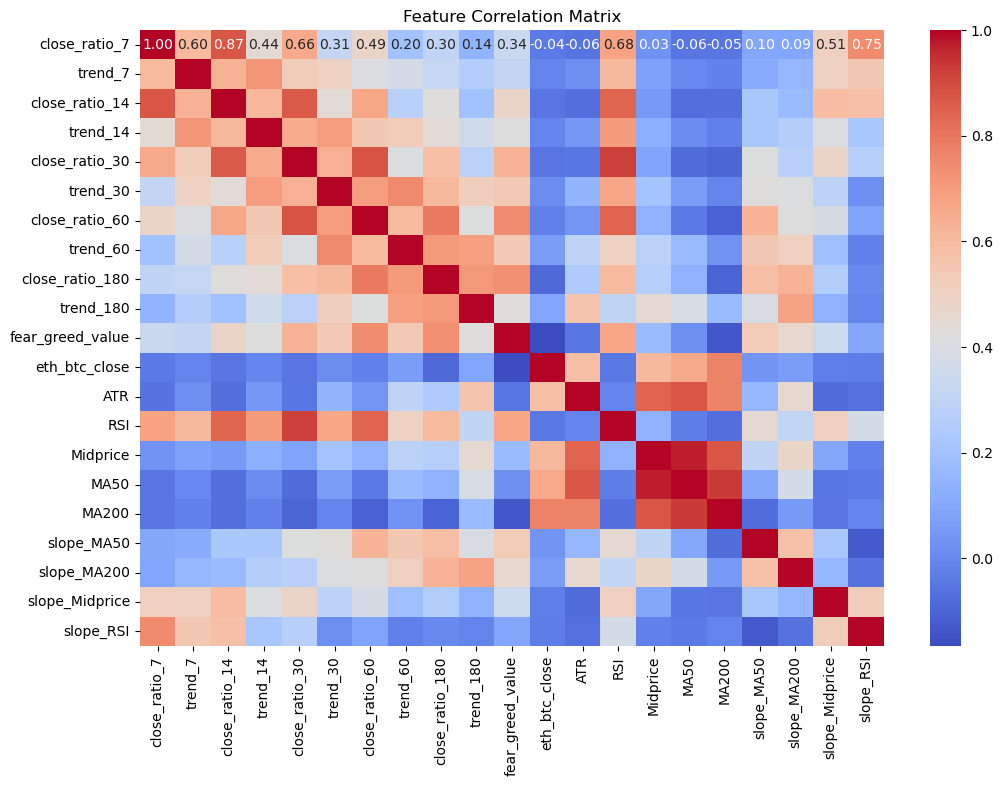

Dropped 12 features.


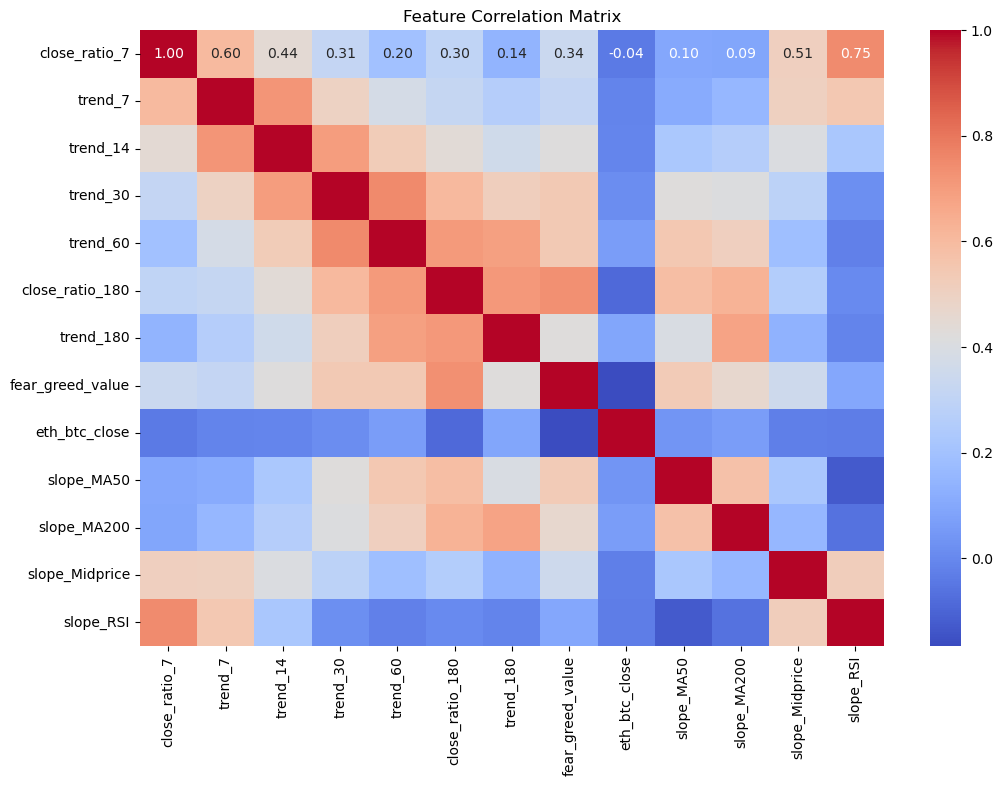

In [9]:
import seaborn as sns

def plot_correlation_matrix(df, features):
    # Calculate the correlation matrix
    df = df[features]
    correlation_matrix = df.corr()

    # Plot the correlation matrix as a heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
    plt.title("Feature Correlation Matrix")
    plt.show()
    
def drop_high_correlation_features(df, features, threshold = 0.8):
    # Calculate the correlation matrix
    correlation_matrix = df.corr()

    # Create a mask to identify correlations that exceed the threshold
    # We use np.triu (upper triangle) to ignore duplicate pairs and self-correlation
    high_corrs = (correlation_matrix.abs() > threshold) & (np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

    # Initialize a list to keep track of columns to drop
    to_drop = set()

    # Iterate over the features with high correlation
    for row, col in zip(*np.where(high_corrs)):
        # Here we use a simple criterion to keep the feature that comes first in the list
        # But you can replace this logic with something more sophisticated if needed
        to_drop.add(correlation_matrix.columns[col])

    # Drop the features from the dataframe
    reduced_df = df.drop(columns=to_drop)
    dropped_features = list(to_drop)
    remaining_features = [i for i in features if i not in dropped_features]

    print(f"Dropped {len(to_drop)} features.")
    return reduced_df, remaining_features


plot_correlation_matrix(df, features)
train_df, remaining_features = drop_high_correlation_features(df, features)
plot_correlation_matrix(train_df, remaining_features)

## Model Evaluation and Feature Significance Analysis
Having pruned our dataset of highly correlated features, we are now positioned to apply machine learning techniques to the refined set of predictors. The RandomForestClassifier, a potent ensemble learning method known for its robustness and versatility, stands as our chosen algorithm. This method operates by constructing multiple decision trees during training and outputting the class that is the mode of the classes for classification tasks.

To harness the full power of the RandomForestClassifier, we employ a two-fold strategy: prediction with evaluation and backtesting. The former involves training the model on a designated training set, followed by evaluating its performance on a separate validation set. This process is encapsulated within the predict_and_evaluate function, where we assess the model's predictive capabilities by calculating log loss, precision, and recall metrics. These metrics collectively provide a comprehensive picture of the model's accuracy, its ability to identify positive instances correctly, and its robustness against false negatives.

Backtesting extends this evaluation across a broader temporal scale, systematically expanding the training window and assessing the model's consistency and adaptability over time. Our backtest_with_evaluation function facilitates this rolling window analysis, offering insights into how the model might perform in various market conditions.
/n
As we proceed with the model training and evaluation, we'll meticulously document the performance metrics, ensuring transparency and reproducibility in our approach. Through a methodical analysis, we aim to build a model that not only captures the underlying patterns in the data but also generalizes well to new, unseen market scenarios.

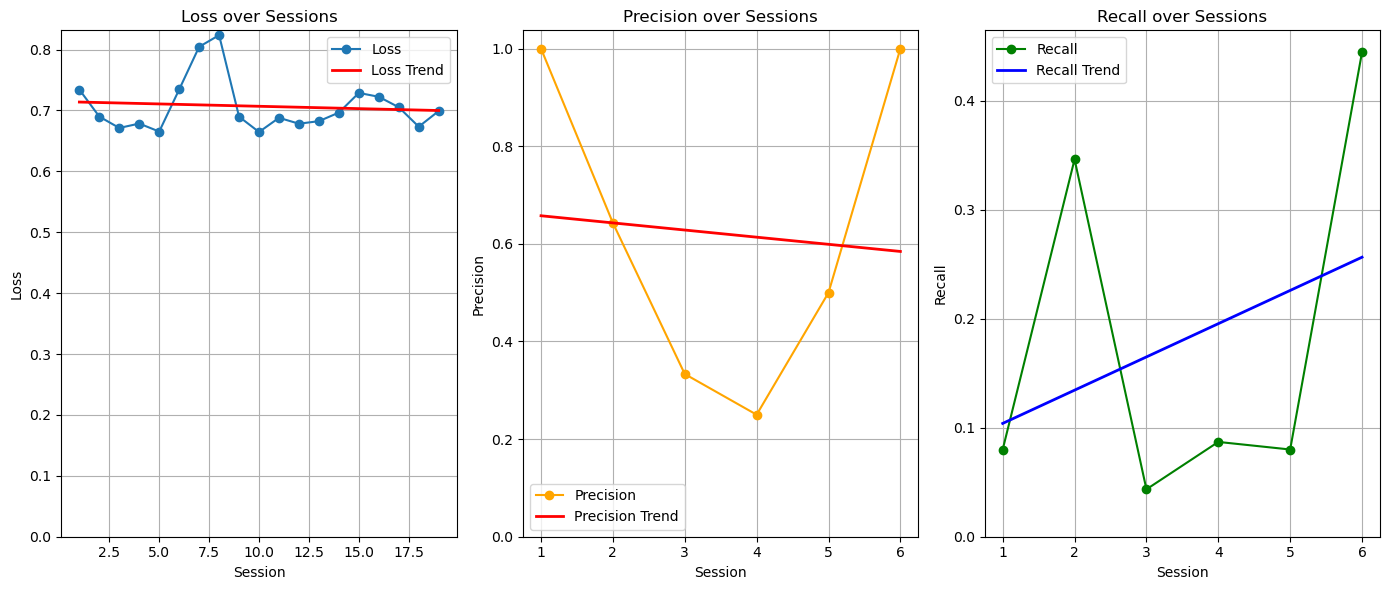

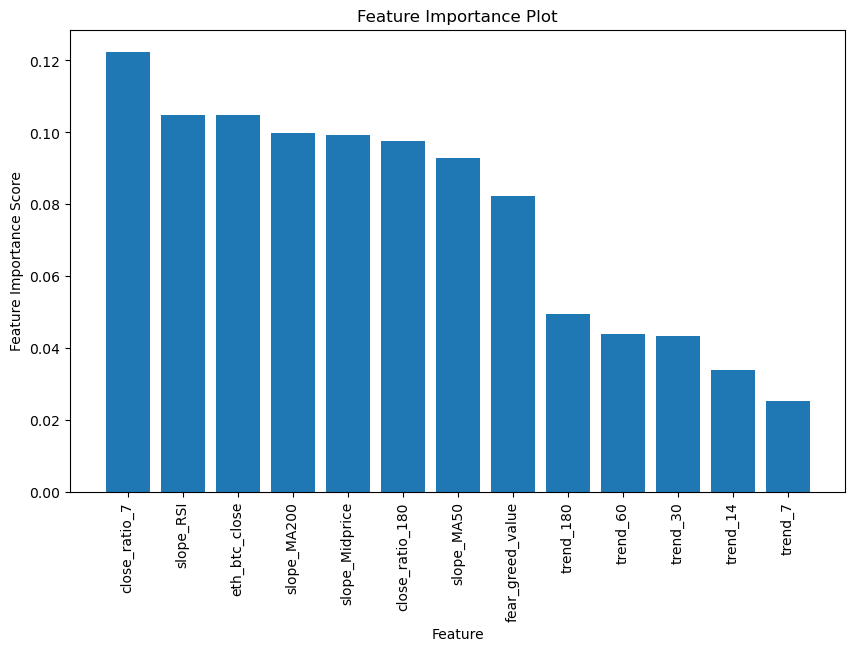

In [10]:
from sklearn.metrics import log_loss, precision_score, recall_score
from scipy.stats import linregress
from sklearn.ensemble import RandomForestClassifier


def predict_and_evaluate(train, validation, predictors, model, confidence):
    """
    Trains the model on the training set and evaluates it on the validation set.

    Parameters:
    - train (DataFrame): Training dataset.
    - validation (DataFrame): Validation dataset.
    - predictors (list): List of predictor column names.
    - model (Model): Machine learning model to train and evaluate.
    - confidence (float): Threshold for classifying a prediction as positive.

    Returns:
    - loss (float): Log loss of the model on the validation set.
    - precision (float): Precision score of the model on the validation set.
    - recall (float): Recall score of the model on the validation set.
    - validation_preds (ndarray): Predictions made by the model on the validation set.
    """
    
    # Train the model
    model.fit(train[predictors], train["target"])
    
    # Make predictions on the validation set
    validation_preds_proba = model.predict_proba(validation[predictors])
    validation_preds = (validation_preds_proba[:,1] >= confidence).astype(int)
    
    # Calculate metrics
    loss = log_loss(validation["target"], validation_preds_proba[:,1])
    # Handle cases with no positive predictions
    if validation_preds.sum() > 0:
        precision = precision_score(validation["target"], validation_preds)
        recall = recall_score(validation["target"], validation_preds)
    else:
        precision = None  # Set to None to indicate no positive predictions were made
        recall = None

    return loss, precision, recall, validation_preds

def backtest_with_evaluation(data, model, predictors, start=300, step=100, confidence=0.65, eval_step=50):
    """
    Performs backtesting over the dataset using rolling windows for training and evaluation.

    Parameters:
    - data (DataFrame): Complete dataset for backtesting.
    - model (Model): Machine learning model for backtesting.
    - predictors (list): List of predictor column names.
    - start (int): Starting index for the initial training window.
    - step (int): Step size to increase the training window for each iteration.
    - confidence (float): Threshold for classifying a prediction as positive.
    - eval_step (int): Number of steps to evaluate the model performance.

    Returns:
    - A tuple containing lists of losses, precisions, recalls, and predictions.
    """
    preds = []
    losses = []
    precisions = []
    precisions = []
    recalls = []
    
    for i in range(start, data.shape[0], step):
        if i + step >= data.shape[0]:
            # Break the loop if there isn't enough data left for training and validation
            break
        train = data.iloc[0:i].copy()
        # Adjust this to ensure you're not trying to validate on an empty set
        if i + step + eval_step < data.shape[0]:
            validation = data.iloc[i+step:i+step+eval_step].copy()
        else:
            validation = data.iloc[i+step:].copy()
    
    for i in range(start, data.shape[0], step):
        if i + step >= data.shape[0]:
            # Break the loop if there isn't enough data left for training and validation
            break
        train = data.iloc[0:i].copy()
        # Adjust this to ensure you're not trying to validate on an empty set
        if i + step + eval_step < data.shape[0]:
            validation = data.iloc[i+step:i+step+eval_step].copy()
        else:
            validation = data.iloc[i+step:].copy()
        if not validation.empty:
            loss, precision, recall, validation_preds = predict_and_evaluate(train, validation, predictors, model, confidence)
            losses.append(loss)
            if precision is not None:  # Only append if there were positive predictions
                precisions.append(precision)
            if recall is not None:  # Only append if there were positive predictions
                recalls.append(recall)
            preds.append(validation_preds)
        else:
            print(f"Skipped evaluation at iteration starting at {i} due to insufficient validation data.")

    return losses, precisions, recalls, preds

            
def print_and_plot_evaluation(losses, precisions, recalls, is_print=True):
    """
    Prints and plots the evaluation results from backtesting.

    Parameters:
    - losses (list): List of log loss values.
    - precisions (list): List of precision scores.
    - recalls (list): List of recall scores.
    - is_print (bool): Flag to control printing of metrics.

    Outputs a plot of loss, precision, and recall over the backtesting sessions.
    """
    
    sessions = range(1, len(losses) + 1)

    # Filter out sessions with no predictions (precision is 0)
    valid_precisions = [p for p in precisions if p > 0]
    valid_sessions_for_precision = [s for s, p in zip(sessions, precisions) if p > 0]
    valid_sessions_for_recall = [s for s, r in zip(sessions, recalls) if r >= 0]  # Assumes recall can be 0 but valid

    # Calculate linear regression for loss, precision (excluding invalid sessions), and recall
    loss_slope, loss_intercept, _, _, _ = linregress(sessions, losses)
    if valid_precisions:
        precision_slope, precision_intercept, _, _, _ = linregress(valid_sessions_for_precision, valid_precisions)
        precision_fit_line = [s * precision_slope + precision_intercept for s in valid_sessions_for_precision]
    recall_slope, recall_intercept, _, _, _ = linregress(valid_sessions_for_recall, recalls)
    recall_fit_line = [s * recall_slope + recall_intercept for s in valid_sessions_for_recall]

    # Plotting
    plt.figure(figsize=(14, 6))

    # Plot for Loss
    plt.subplot(1, 3, 1)
    plt.plot(sessions, losses, marker='o', label='Loss')
    plt.plot(sessions, [s * loss_slope + loss_intercept for s in sessions], label='Loss Trend', color='red', linewidth=2)
    plt.title('Loss over Sessions')
    plt.xlabel('Session')
    plt.ylabel('Loss')
    plt.ylim(bottom=0)
    plt.grid(True)
    plt.legend()

    # Plot for Precision
    plt.subplot(1, 3, 2)
    if valid_precisions:
        plt.plot(valid_sessions_for_precision, valid_precisions, marker='o', color='orange', label='Precision')
        plt.plot(valid_sessions_for_precision, precision_fit_line, label='Precision Trend', color='red', linewidth=2)
        plt.title('Precision over Sessions')
        plt.xlabel('Session')
        plt.ylabel('Precision')
        plt.ylim(bottom=0)
        plt.grid(True)
        plt.legend()

    # Plot for Recall
    plt.subplot(1, 3, 3)
    plt.plot(valid_sessions_for_recall, recalls, marker='o', color='green', label='Recall')
    plt.plot(valid_sessions_for_recall, recall_fit_line, label='Recall Trend', color='blue', linewidth=2)
    plt.title('Recall over Sessions')
    plt.xlabel('Session')
    plt.ylabel('Recall')
    plt.ylim(bottom=0)
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()
    
def plot_feature_importance(features, model):
    """
    Plots the feature importance of a trained model.

    Parameters:
    - features (list): List of feature names.
    - model (Model): Trained machine learning model.

    Outputs a bar plot showing the importance of each feature.
    """
    # Access feature importances from your trained Random Forest model
    feature_importances = model.feature_importances_

    # Sort feature importances in descending order
    sorted_idx = feature_importances.argsort()[::-1]

    # Create a bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(feature_importances)), feature_importances[sorted_idx])
    plt.xticks(range(len(feature_importances)), [features[i] for i in sorted_idx], rotation=90)
    plt.xlabel('Feature')
    plt.ylabel('Feature Importance Score')
    plt.title('Feature Importance Plot')
    plt.show()

train_df = df
train_df = train_df.dropna()
    
# Define and initialize the model
model = RandomForestClassifier(n_estimators=250, min_samples_split=25, random_state=1)
    
losses, precisions, recalls, preds = backtest_with_evaluation(train_df, model, remaining_features)
print_and_plot_evaluation(losses, precisions, recalls, is_print=False)
plot_feature_importance(remaining_features, model)


### Interpreting Feature Importance

The feature importance plot offers a visual representation of which features most significantly impact the model's predictions. The plot highlights that features such as the slope of the Relative Strength Index (`slope_RSI`), the closing price ratio over a 14-day horizon (`close_ratio_14`), and the Ethereum to Bitcoin closing price ratio (`eth_btc_close`) are among the most influential in the model. 

In contrast, trend-related features (`trend_180`, `trend_60`, `trend_30`, `trend_14`) have lower importance scores. Given their limited impact on the model's decisions, we'll try removing them from the feature list and reassessing the feature correlation and model training results. By doing so, we could potentially streamline the feature set, focusing the model's learning process on the most relevant predictors and hopefully increase the precision and decrease the loss over sessions.


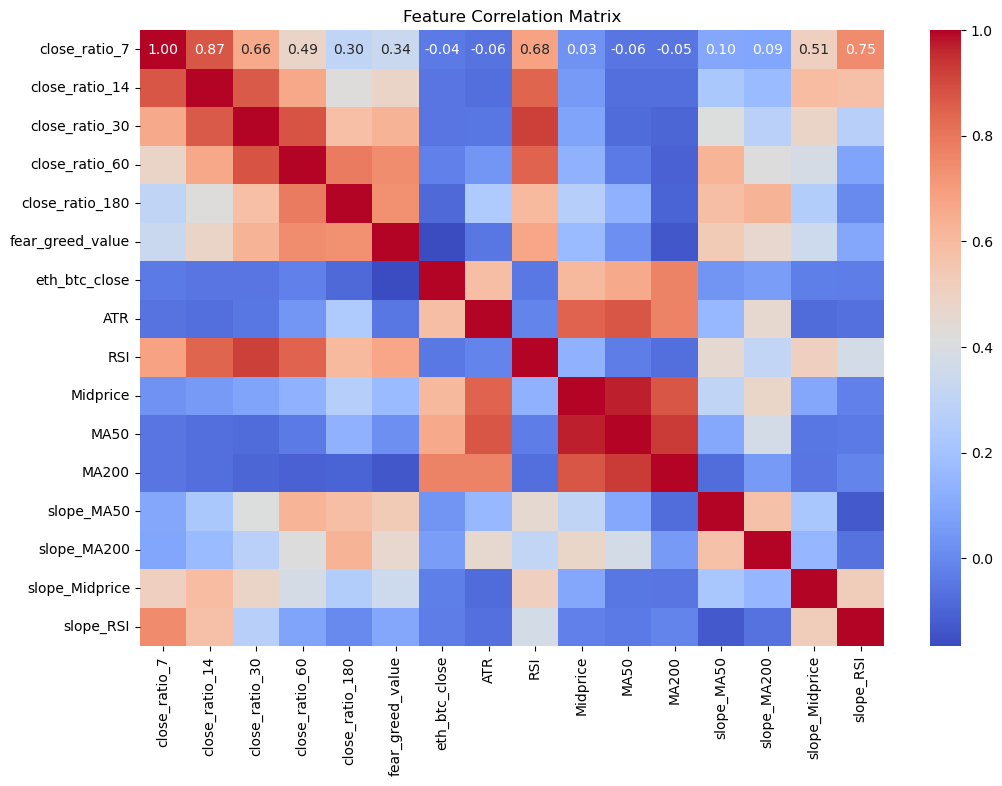

Dropped 12 features.


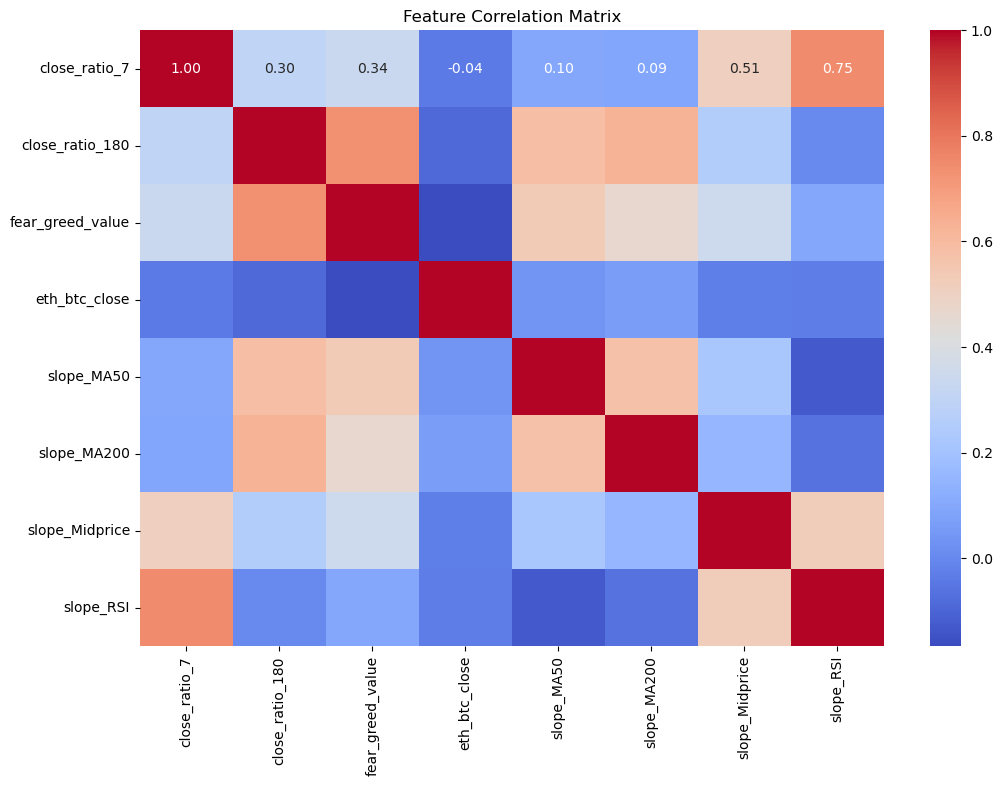

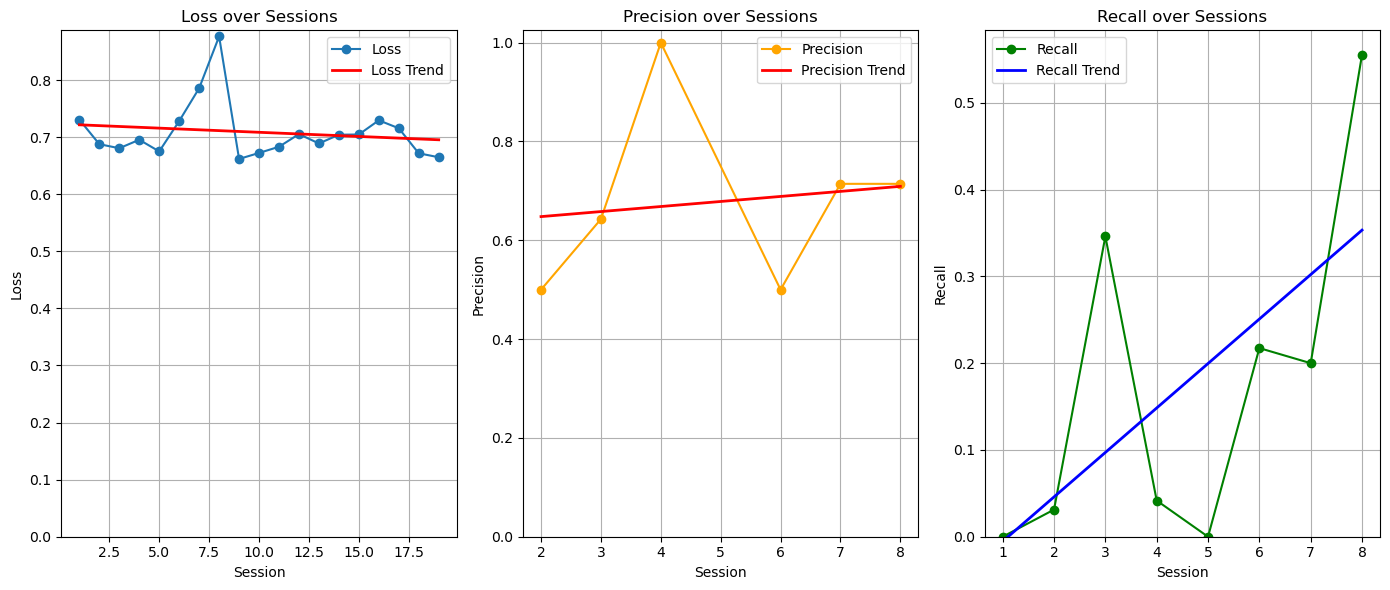

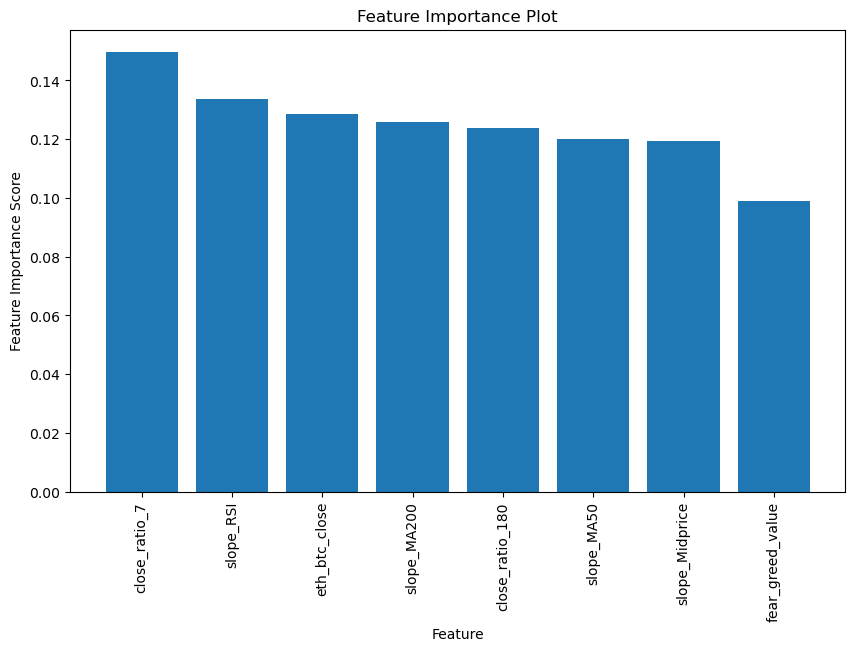

In [11]:
trend_features = ['trend_2', 'trend_7', 'trend_14', 'trend_30', 'trend_60', 'trend_180', 'trend_365']
new_features = [i for i in features if i not in trend_features]

plot_correlation_matrix(df, new_features)
train_df, remaining_features = drop_high_correlation_features(df, new_features)
plot_correlation_matrix(train_df, remaining_features)

train_df = train_df.dropna()
losses, precisions, recalls, preds = backtest_with_evaluation(train_df, model, remaining_features)
print_and_plot_evaluation(losses, precisions, recalls, is_print=False)
plot_feature_importance(remaining_features, model)


Following the feature correlation analysis and the assessment of feature importance, we have distilled a refined set of features to power our predictive model for Ethereum's next-day price movements. The feature importance plot revealed that certain features like the `slope_RSI` and `close_ratio_7` hold significant predictive value. Conversely, the high correlation among several features suggests redundancy. For exmaple when looking at the `close_ratio_180` and the `fear_greed_value`. This corelation might make sense if you consider that if the `close_ratio_180`, you would assume the sentiment in the market will be positive (greedy) and vice versa.

We observed that while trend features possess lower importance scores, they may still play a vital role when combined with ratio and sentiment indicators, creating a balanced and comprehensive model. Interestingly, Ethereum's price shows some dependency on Bitcoin's performance, indicated by the moderate importance of eth_btc_close, though it's not the primary driver.

Moving forward with hyperparameter tuning, this optimized and leaner feature set should help in enhancing the model's generalization capabilities, ensuring robust performance across various market conditions. This step is crucial to avoid overfitting and to capture the true underlying patterns in cryptocurrency price movements.

# Hyperparameter Tuning and Model Validation


In machine learning, particularly in complex models like the Random Forest we're utilizing here, selecting the right hyperparameters is essential. These hyperparameters are the settings that govern the model's learning process and structure. To ensure our model isn't just memorizing our data (overfitting), but rather learning from it to make accurate predictions on new, unseen data, we need to fine-tune these settings.

For our model, we focus on three key hyperparameters:

- Number of Trees (n_estimators): This represents the number of trees in our forest. Generally, more trees lead to better performance but also increase computation. We must find a sweet spot where our model performs well without unnecessary computational costs.

- Maximum Depth of Trees (max_depth): This defines how deep each tree can grow. Deeper trees can model more complex patterns but might learn noise in our training data leading to overfitting. We want a depth that allows the model to learn underlying patterns without catching the noise.

- Minimum Samples per Split (min_samples_split): It determines the minimum number of samples required to split an internal node. Higher values prevent the model from learning too much detail from the training data while too low values might cause overfitting by making the model too complex.

We approach hyperparameter tuning methodically. We start by defining a reasonable range for each parameter based on our understanding of the dataset and model. Then, we train models across a grid of hyperparameter values within these ranges, using our training data. Each model's performance is then evaluated on a separate validation set — data that the model hasn't seen before, which helps us gauge how well it generalizes.

To keep our model from overfitting, we perform this evaluation by checking the precision of the model predictions — we want our model to be precise in its predictions of upward price movement. For practical reasons, we use a subset of data for these initial tests to account for the fast-paced changes in the cryptocurrency market, ensuring our model is tested under conditions similar to real-world trading.

Lastly, we look at the top-performing models from our validation set, and run a final check against a test set — another batch of new, unseen data. This step gives us confidence that our chosen hyperparameters will likely perform well in live trading conditions.

In [12]:
DAYS_TO_TRAIN = 400
TEST_STEP = 200 # Using larger step size to avoid a case of no predicitons.

train = train_df.iloc[:DAYS_TO_TRAIN]
test_set_1 = train_df.iloc[DAYS_TO_TRAIN: DAYS_TO_TRAIN+TEST_STEP]
test_set_2 = train_df.iloc[DAYS_TO_TRAIN+TEST_STEP: DAYS_TO_TRAIN+TEST_STEP*2]


# Define hyperparameters ranges
import itertools
import random

amount_of_parameters = 10
range_n_estimators = (10, 1000)
range_max_depth = (2,30)
range_min_samples_split = (2, 100)
# range_max_samples = (0, 1)
# range_max_features = (0, 1)
parameter_list = []
model_list = []

# create sets of random numbers within the range for each hyperparameter
parameter_list.append({random.randint(range_n_estimators[0], range_n_estimators[1]) for _ in range(amount_of_parameters)})
parameter_list.append({random.randint(range_max_depth[0], range_max_depth[1]) for _ in range(amount_of_parameters)})
parameter_list.append({random.randint(range_min_samples_split[0], range_min_samples_split[1]) for _ in range(amount_of_parameters)})


  
param_combinations = list(itertools.product(*parameter_list))

for index, combination in enumerate(param_combinations):
    # print(f"Index {index}: {combination}")
    model = RandomForestClassifier(n_estimators=combination[0], max_depth=combination[1], min_samples_split=combination[2], random_state=1)
    model_list.append((model, combination))
print(model_list)
        

[(RandomForestClassifier(max_depth=4, min_samples_split=96, n_estimators=385,
                       random_state=1), (385, 4, 96)), (RandomForestClassifier(max_depth=4, min_samples_split=97, n_estimators=385,
                       random_state=1), (385, 4, 97)), (RandomForestClassifier(max_depth=4, min_samples_split=34, n_estimators=385,
                       random_state=1), (385, 4, 34)), (RandomForestClassifier(max_depth=4, min_samples_split=66, n_estimators=385,
                       random_state=1), (385, 4, 66)), (RandomForestClassifier(max_depth=4, min_samples_split=74, n_estimators=385,
                       random_state=1), (385, 4, 74)), (RandomForestClassifier(max_depth=4, min_samples_split=43, n_estimators=385,
                       random_state=1), (385, 4, 43)), (RandomForestClassifier(max_depth=4, min_samples_split=15, n_estimators=385,
                       random_state=1), (385, 4, 15)), (RandomForestClassifier(max_depth=4, min_samples_split=80, n_estimators=385

Now that we have a list with different models and combinations of hyperparameters and their values, we only need to train each model on the training set and then run each model on the validation set. We are going to create a new DataFrame called models_df in which we'll store our models and the validation set precision, which will be saved under the precision column. For each model, we'll print its precision score, and in the end, we'll print the models DataFrame to see all the models we've received.

I'm also creating here a more simplistic version of the test and predict methods, since we are not interested in the plotting and graphs but rather only the precision at this point.

Then we could compare and see what are the best combinations and values for each parameter.

predicting model number 0...
Precision for BUY class: 0.5316455696202531
predicting model number 1...
Precision for BUY class: 0.5316455696202531
predicting model number 2...
Precision for BUY class: 0.5321100917431193
predicting model number 3...
Precision for BUY class: 0.494949494949495
predicting model number 4...
Precision for BUY class: 0.5052631578947369
predicting model number 5...
Precision for BUY class: 0.5476190476190477
predicting model number 6...
Precision for BUY class: 0.5087719298245614
predicting model number 7...
Precision for BUY class: 0.5111111111111111
predicting model number 8...
Precision for BUY class: 0.47959183673469385
predicting model number 9...
Precision for BUY class: 0.48
predicting model number 10...
Precision for BUY class: 0.525
predicting model number 11...
Precision for BUY class: 0.5454545454545454
predicting model number 12...
Precision for BUY class: 0.528
predicting model number 13...
Precision for BUY class: 0.5142857142857142
predicting mod

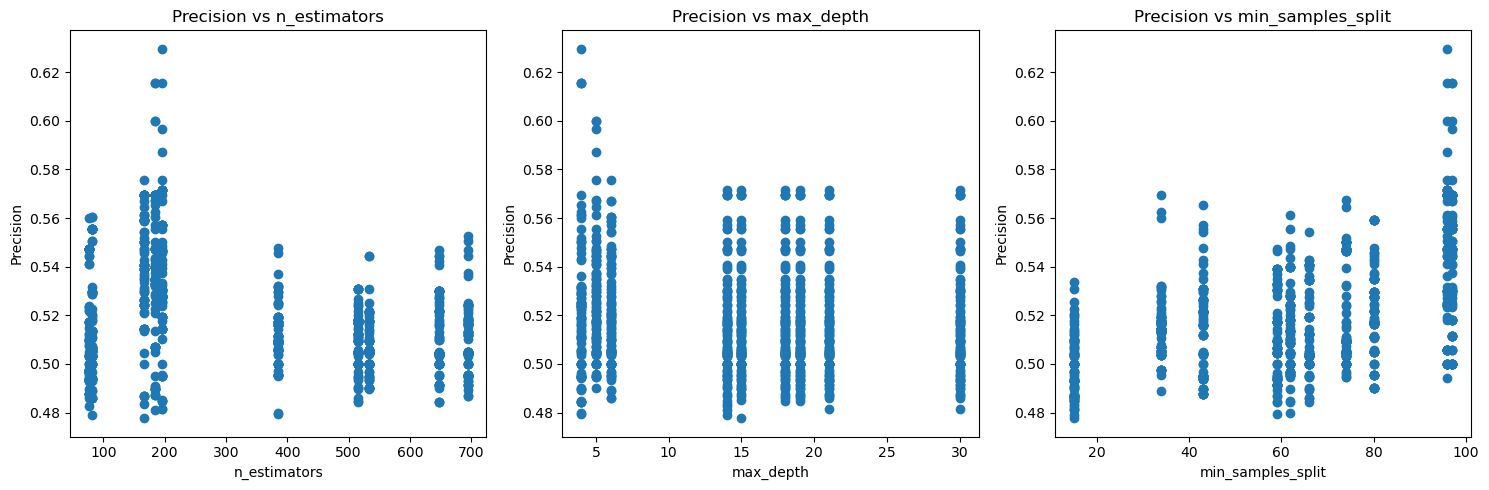

In [13]:
def plot_params(df, column):

    # Create three separate scatter plots
    plt.figure(figsize=(15, 5))

    plt.subplot(131)
    plt.scatter(df['n_estimators'], df[column])
    plt.xlabel('n_estimators')
    plt.ylabel('Precision')
    plt.title('Precision vs n_estimators')

    plt.subplot(132)
    plt.scatter(df['max_depth'], df[column])
    plt.xlabel('max_depth')
    plt.ylabel('Precision')
    plt.title('Precision vs max_depth')

    plt.subplot(133)
    plt.scatter(df['min_samples_split'], df[column])
    plt.xlabel('min_samples_split')
    plt.ylabel('Precision')
    plt.title('Precision vs min_samples_split')

    plt.tight_layout()
    plt.show()

def test_predict_model(train, test, predictors, model, confidence=0.5):
    model.fit(train[predictors], train["target"])
    return predict_model(test, predictors, model, confidence)

def predict_model(test, predictors, model, confidence=0.5):
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >= confidence] = 1
    preds[preds < confidence] = 0
    return pd.DataFrame(preds, columns=["preds"])


final_predictors = remaining_features
models_df = pd.DataFrame(model_list)

precision_list = []

for index, (model, param_combination) in enumerate(model_list):
    # WE HAVE TO USE 0.5 CONFIDENCE FOR THIS OTHERWISE WE WON'T HAVE PREDCITIONS
    preds = test_predict_model(train, test_set_1, remaining_features, model, confidence=0.5)
    print(f"predicting model number {index}...")
    # print(f'the traget is:\n{predictions["target"]}\n the predictions are:\n{predictions["predicitons"]}')
    
    # calculate precision and add to models_df
    # WE HAVE TO USE 0.5 CONFIDENCE FOR THIS OTHERWISE WE WON'T HAVE PREDCITIONS
    precision_buy = precision_score(test_set_1["target"], preds["preds"], labels=[1], average=None)
    print("Precision for BUY class:", precision_buy[0])
    precision_list.append(precision_buy[0])
    
models_df["precision"] = precision_list

# Name the hyperparameters column
models_df = models_df.rename(columns={0: "model", 1: "hyperparam"})

# Split the 'hyperparameters' column into three separate columns
models_df[['n_estimators', 'max_depth', 'min_samples_split']] = pd.DataFrame(models_df['hyperparam'].to_list(), index=models_df.index)
models_df.drop('hyperparam', axis=1, inplace=True)


print(models_df)

plot_params(models_df, 'precision')

## Early Stopping
In machine learning, as models with high learning capacity train, they often exhibit a pattern where training error steadily decreases, but validation error starts to increase after a certain number of epochs. This increase in validation error is a sign of overfitting, where the model becomes too specialized in fitting the training data, losing its ability to generalize to unseen data.

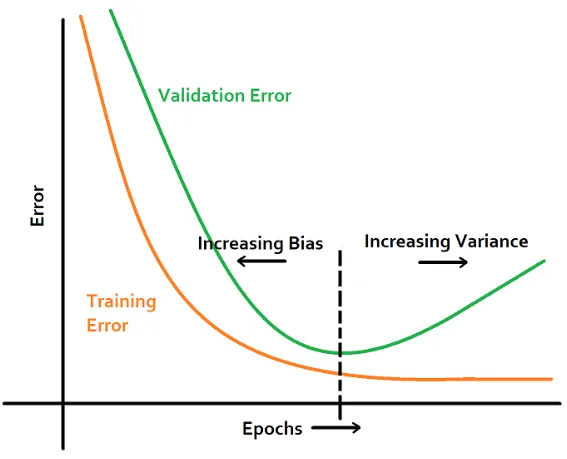

To address this issue, regularization techniques like early stopping are employed. Early stopping involves monitoring the model's performance on a validation dataset during training and stopping when validation error begins to worsen over consecutive epochs. By doing this, early stopping helps strike a balance between model complexity and generalization, preventing overfitting and ensuring the model can make accurate predictions on new, unseen data. It's a valuable tool for building robust machine learning models.

In order to incorporate early stopping to our model, we will examine the drop between the train precision and validation precision and plot it to see the model's performance on the train and validation sets. based on that we'll then decide when our validation error is starting to grow compared to the training error, and that would be the point in which our model begins to overfit! We'll then choose the best models up to this threshhold!

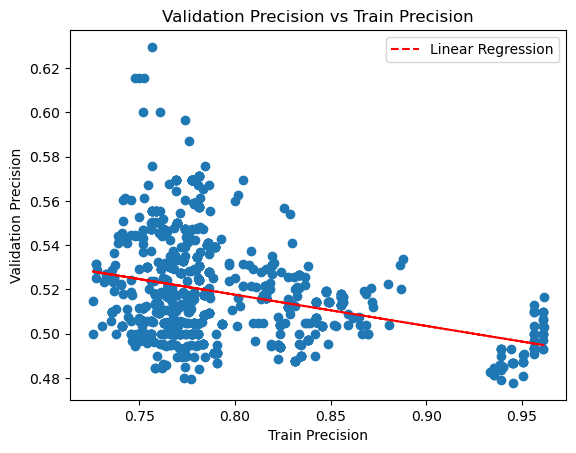

In [14]:
NUM_OF_BEST_MODELS = 5
precision_list = []

for col_name, col_vals in models_df.items():
    if col_name == "model":
        for model in col_vals:
            
            preds = predict_model(train, remaining_features, model, confidence=0.5)
            precision_buy = precision_score(train["target"], preds["preds"], labels=[1], average=None)
            precision_list.append(precision_buy[0])
            #print(test_set_2)
            #print(model, precision_buy[0])

            
#get top models by validation precision (first test)
models_df["train_precision"] = precision_list
models_df["validation_error"] = models_df["train_precision"] - models_df["precision"]
best_models_df = models_df.sort_values(by='precision', ascending=False).head(NUM_OF_BEST_MODELS)


# plot validation error
#plot_params(models_df, 'Train Precision vs Validation Precision')


plt.scatter(models_df["train_precision"], models_df["precision"])
plt.xlabel('Train Precision')
plt.ylabel('Validation Precision')
plt.title('Validation Precision vs Train Precision')


regression_coefficients = np.polyfit(models_df["train_precision"], models_df["precision"], 1)
regression_line = np.poly1d(regression_coefficients)

# Plot the linear regression line
plt.plot(models_df["train_precision"], regression_line(models_df["train_precision"]), color='red', linestyle='--', label='Linear Regression')

plt.legend()
plt.show()

As we can see from the linear regression of the graph we plotted above, the higher the train precision of a model was, the more it tended to be overfit. We can also see that we have a lot of models which had great precision in training and also had pretty good precision in validation with a pretty low drop in performance (a drop is expected).

Something else that's very visible, is that there are 2 main clusters
1. a cluster at the bottom right which cnsists of (probably) overfit models
2. a main cluster between 0.75 and 0.85 of the Train Precisionwhich consists of more balanced models, that are less likely to be overfit

In order to choose a model with good results that is very unlikely to overfit, we will take the best 5 models by precision, where their train precision is lower than 0.8.

In the next step, we'll sort out the overfit models and sort our models by their validation precision. Then we're going to test them on an additional epoch of data to simulate "testing our model in real time". We'll then plot the precision for each hyperparameter.

By letting our model run on the test set, we're providing an unbiased validation that our model indeed performs well in real time.

We're going to do this step with only the 5 best models from the last step. The reason is that in the real world, this would be the phase in which we go and try the model in the real world. We want to pick only the best models up to this point.

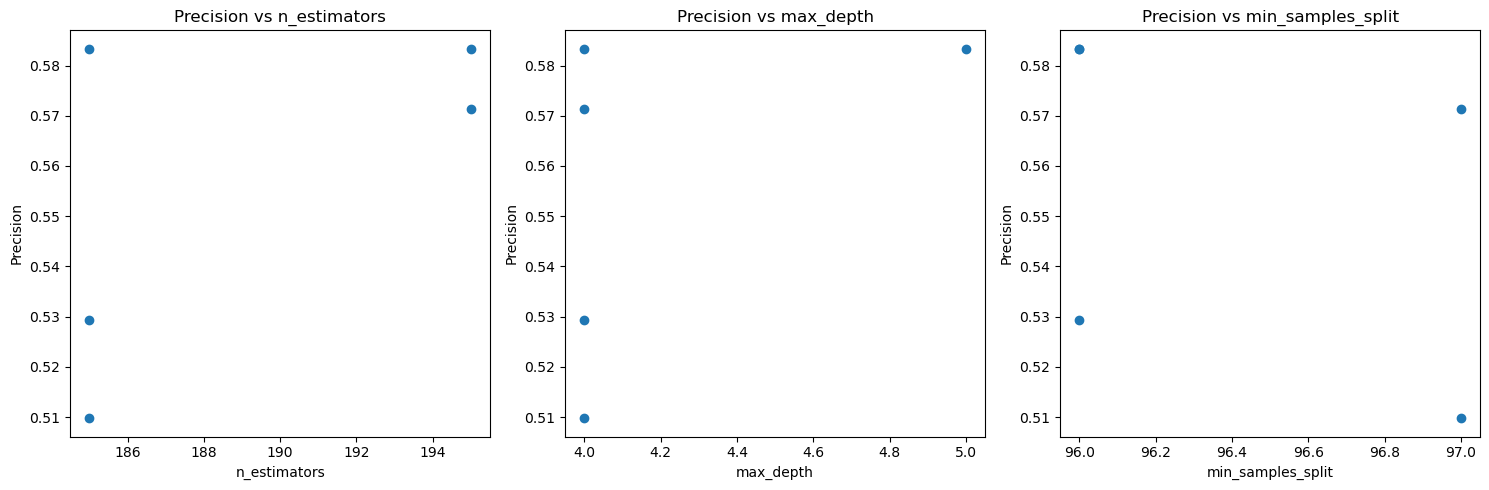

[]

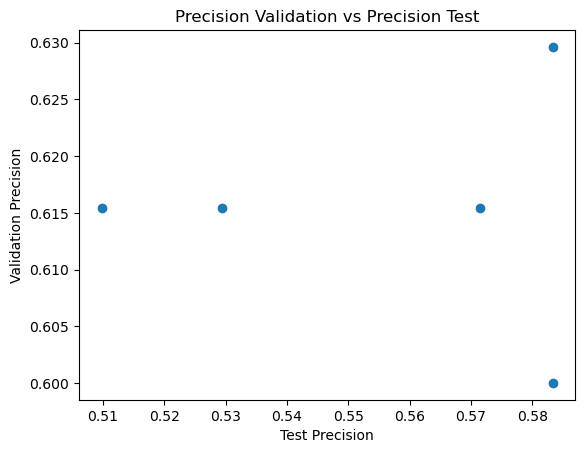

In [15]:
NUM_OF_BEST_MODELS = 5

filtered_df = models_df[models_df["train_precision"] < 0.8]
sorted_df = filtered_df.sort_values(by="precision", ascending=False)
best_sorted_df = sorted_df.copy().head(NUM_OF_BEST_MODELS)

precision_list = []

for col_name, col_vals in best_sorted_df.items():
    if col_name == "model":
        for model in col_vals:
            preds = predict_model(test_set_2, remaining_features, model, confidence=0.5)
            precision_buy = precision_score(test_set_2["target"], preds["preds"], labels=[1], average=None)
            precision_list.append(precision_buy[0])

            
#add the test precision to the best_sorted_df and plot vs each hyperparameter
best_sorted_df["test_precision"] = precision_list
plot_params(best_sorted_df, 'test_precision')

# plot the test precision vs validation precision
plt.scatter(best_sorted_df["test_precision"], best_sorted_df["precision"])
plt.xlabel('Test Precision')
plt.ylabel('Validation Precision')
plt.title('Precision Validation vs Precision Test')
plt.plot()

As we would expect, the accuracy of the models when running on the test set was overall lower than the results we got when running them on the validation set. The reason is very simple - since we did not fit the model on the validation set, there is a 'gap' in the model's knowledge, and that's why it's giving worse results. Essentially, what's happening is that we train the model on the data of the first 400 days and then we let it predict the price movement starting from 200 days from the last day the data was trained on. Obviously, this is a harder task than trying to predict the next 50 days.


# The Final Simulation

Now that we've conifgured our hyperparameters, features and model. Let's run our top 5 models from the last part of the project to see how they do in real time!

In this section, we conduct a thorough backtesting process to evaluate the efficacy of our predictive models in a simulated trading environment. The methodology involves executing a series of trades based on the models' predictions, commencing at a significant juncture in the dataset to assess performance over an extended period.

The procedure begins 300 days into the dataset, proceeding with systematic increments to the dataset's temporal boundaries. A judiciously selected confidence threshold is applied to filter the trade signals generated by the models. This threshold has been calibrated to optimize the balance between risk and potential return.

The essence of this exercise is to determine wether our models can be used in real life, and to see how they perform in real time. It serves as a litmus test for the models' ability to not only identify profitable trading opportunities but also to adapt to the inherent volatility of the cryptocurrency markets.

This quantitative backtesting is crucial—it not only validates the models against historical data but also provides insights for potential enhancements. The outcomes of this simulation will guide future iterations and refinements of our trading strategies, ensuring a data-driven and methodological approach to algorithmic trading.

To simulate trading, I've implemented a `simulate_trading` function that tracks the price performance of our portfolio, purchasing ETH for each buy signal the model generates and selling it the next day. In the end, it will present the Profit and Loss on a chart to visualize the results.


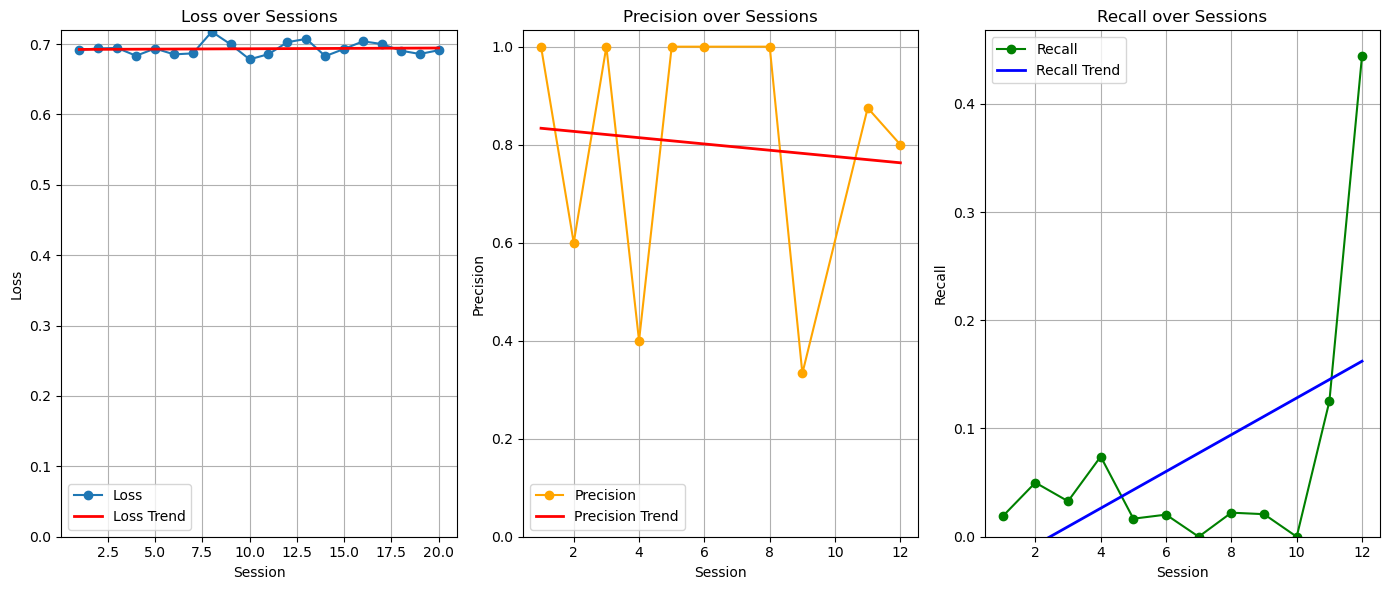

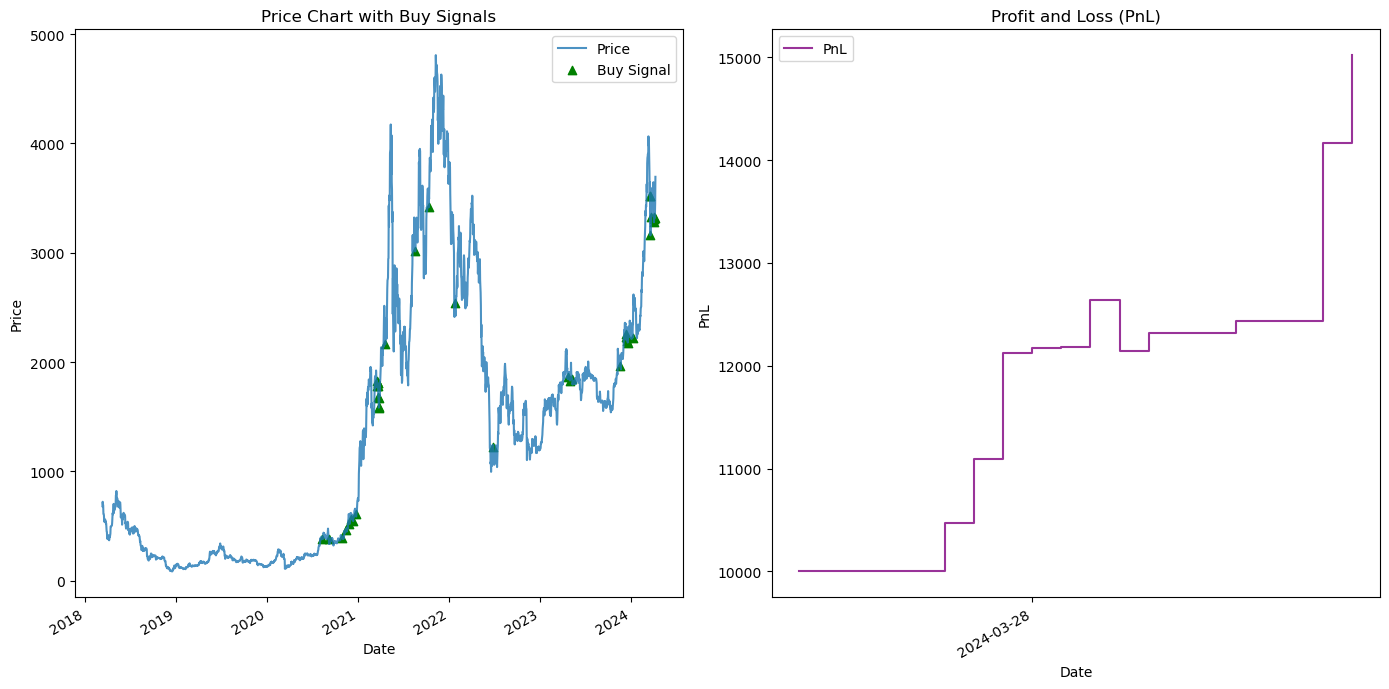

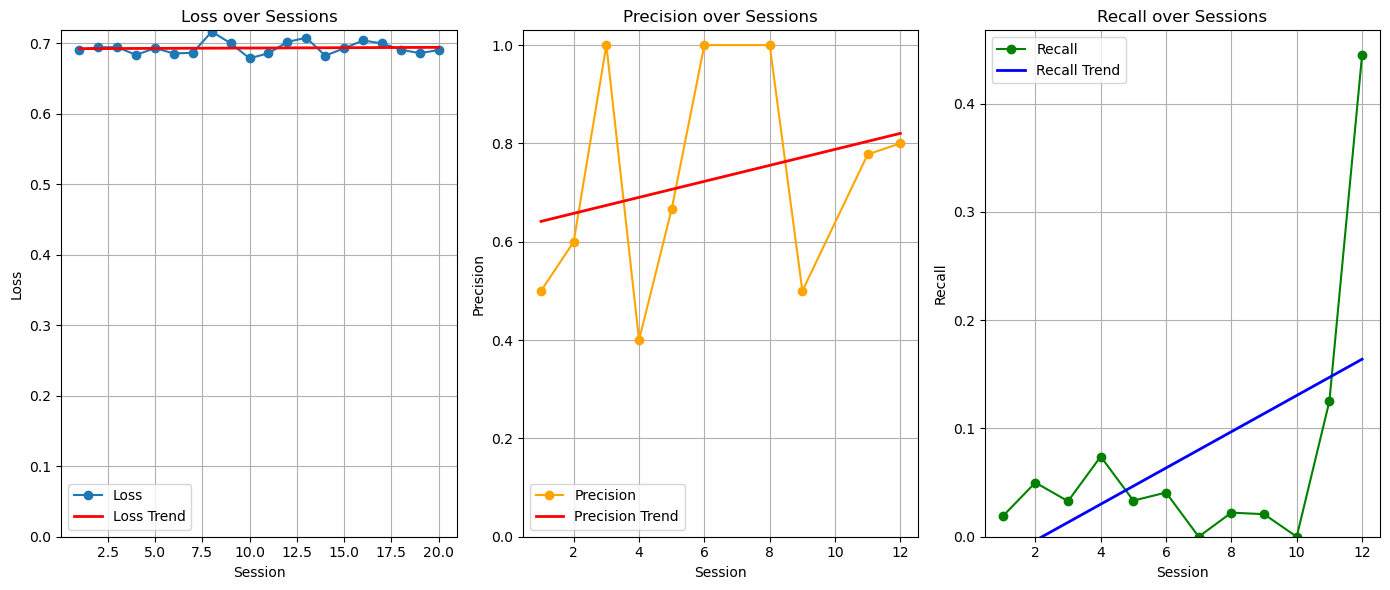

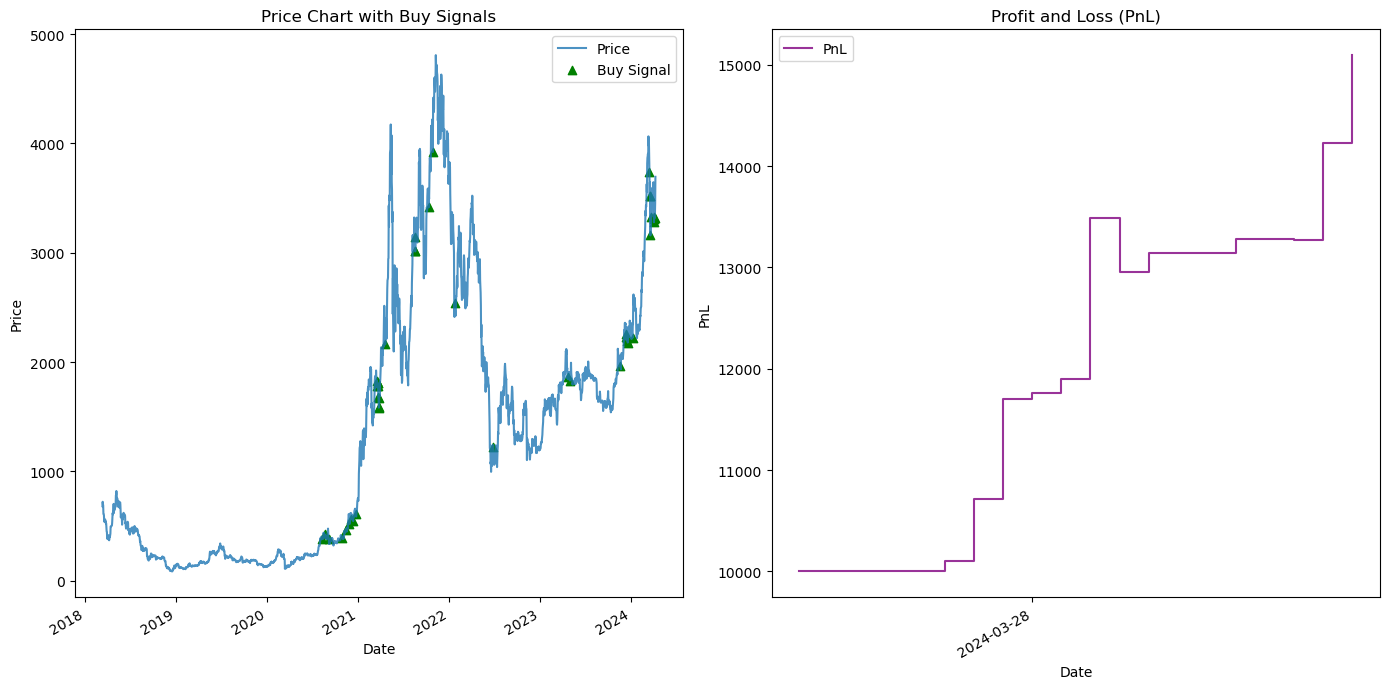

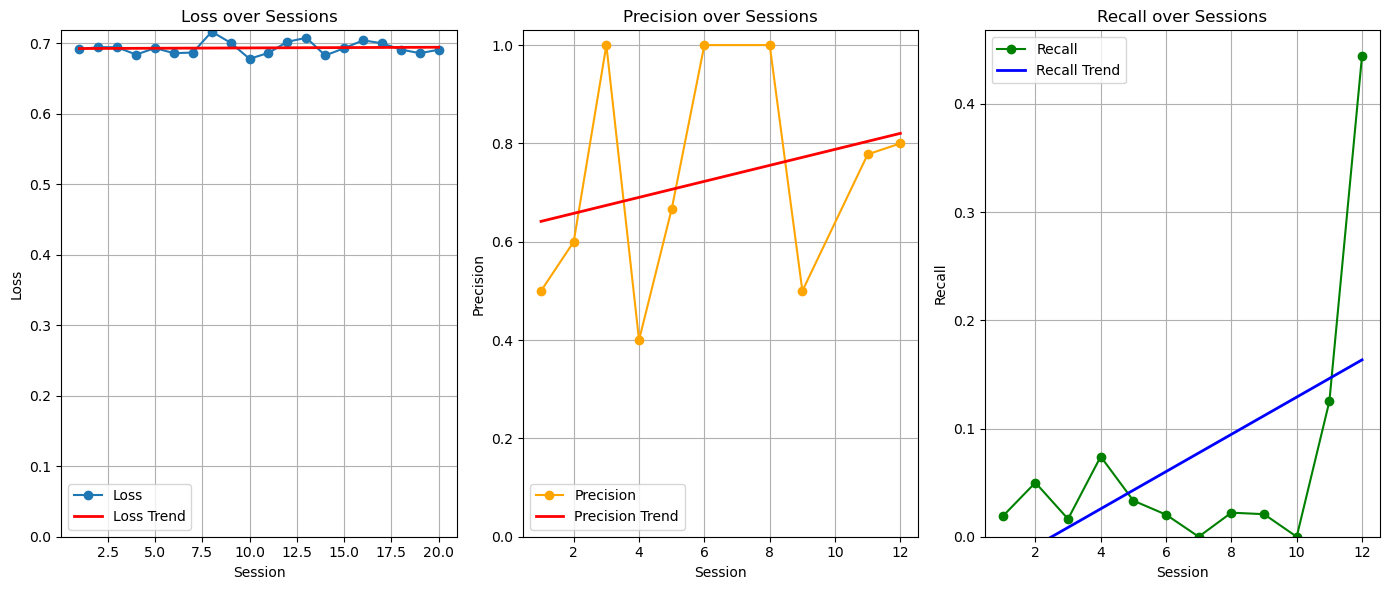

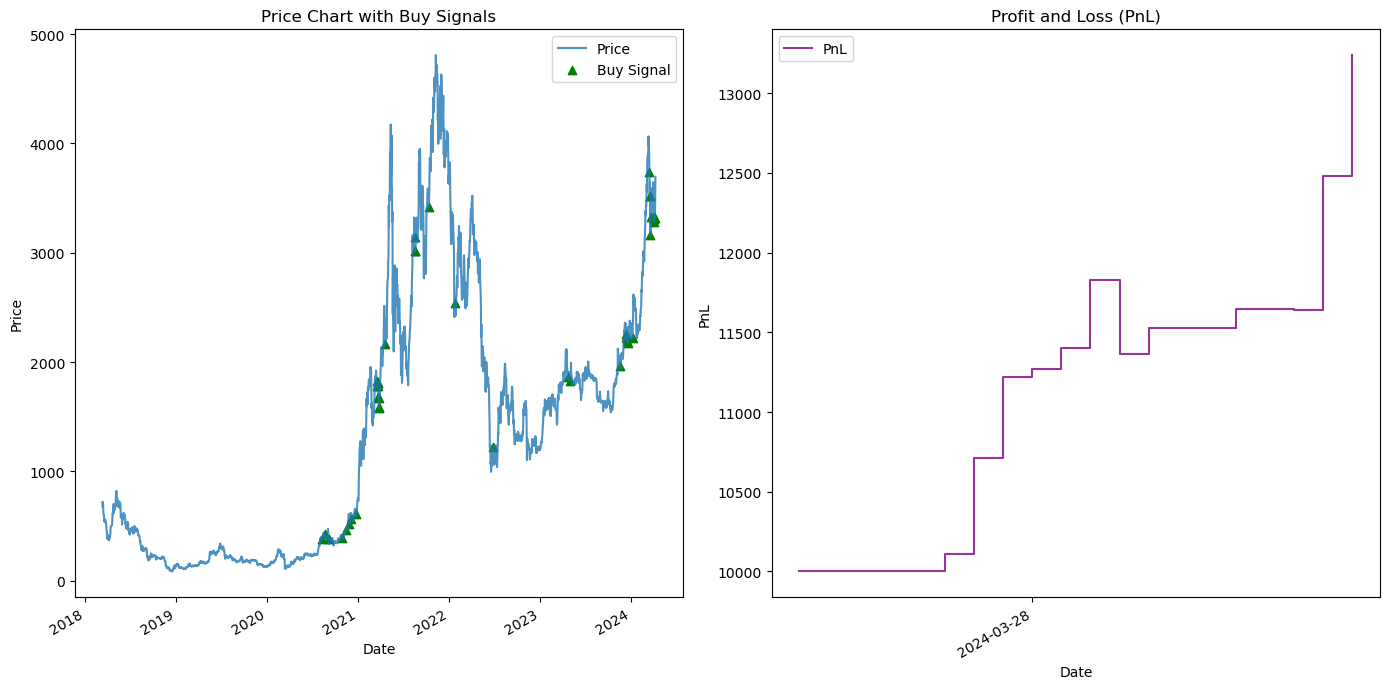

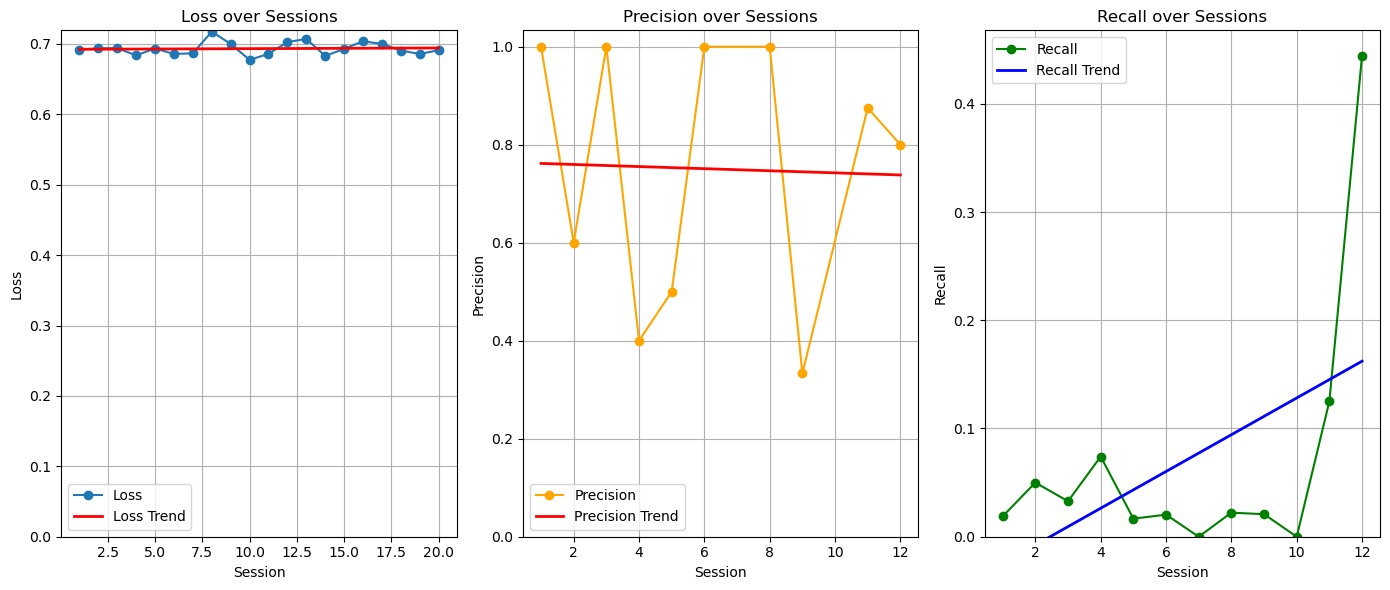

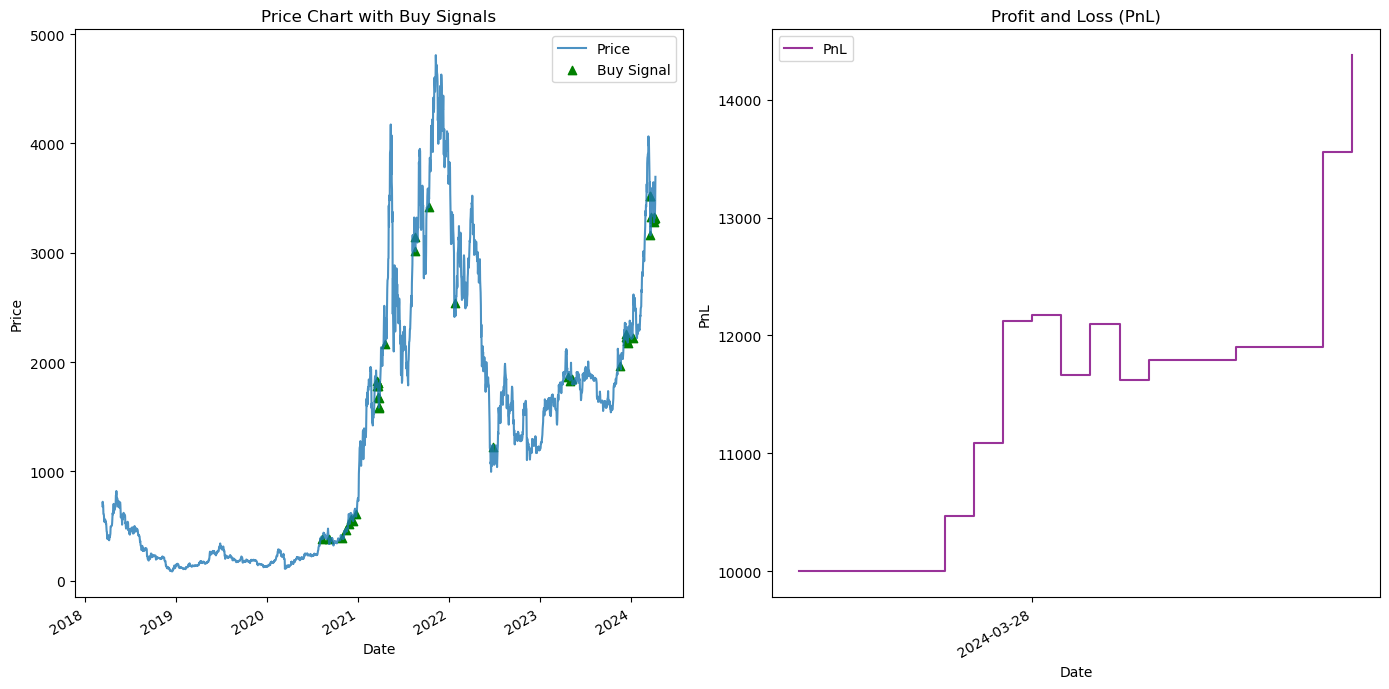

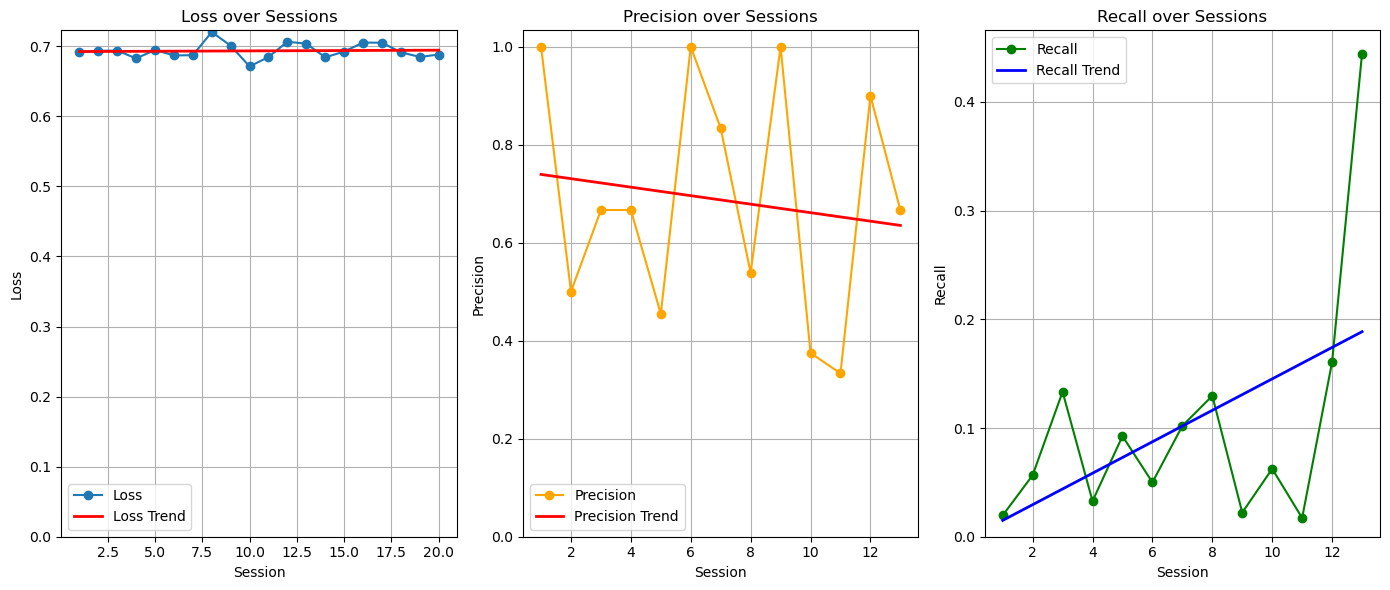

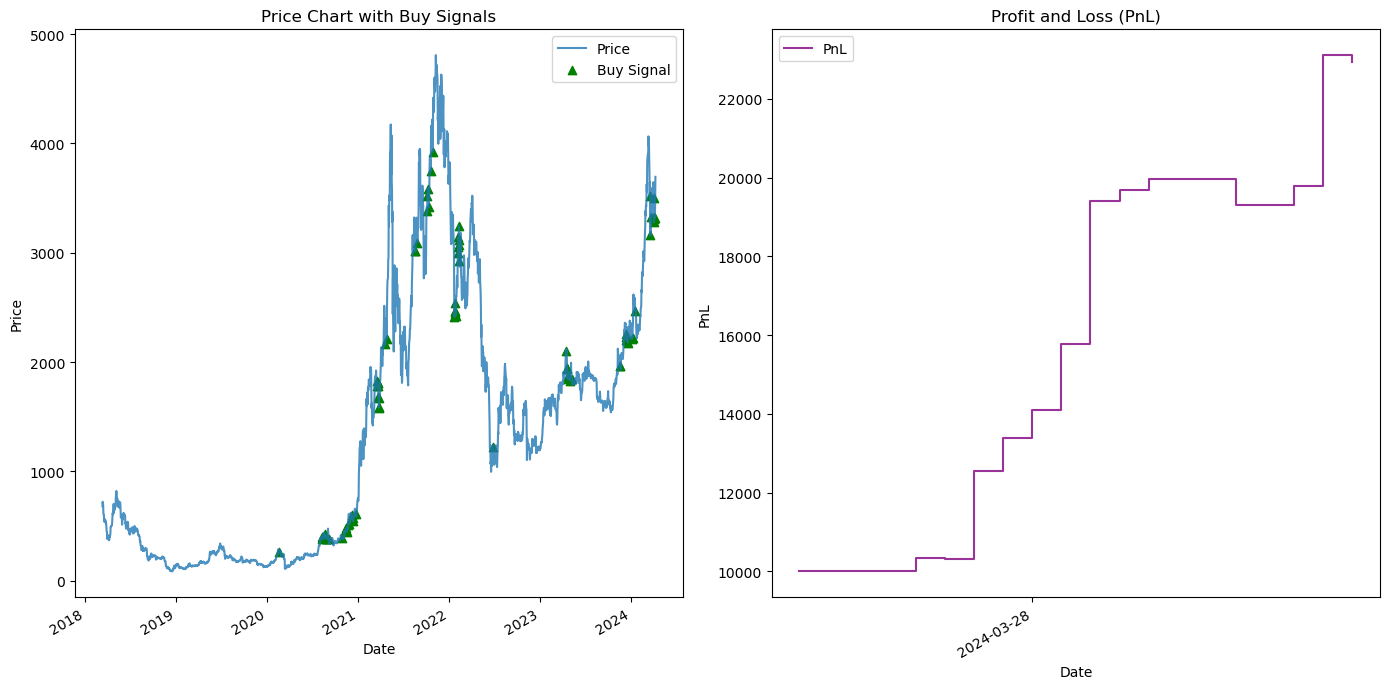

In [16]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

TOP_MODELS_NUM = 10

def backtest_with_trading_simulation(data, model, predictors, start=300, step=100, confidence=0.65, eval_step=50, initial_balance=10000):
    """
    Backtest a trading model with rolling window prediction and trading simulation.

    Parameters:
    - data: DataFrame containing the market data and features for backtesting.
    - model: The machine learning model to be backtested.
    - predictors: List of feature columns to use for prediction.
    - start: Index to start the rolling window for training the model.
    - step: Number of days to move the rolling window forward for each iteration.
    - confidence: The threshold for the model to trigger a trade signal.
    - eval_step: The number of days to evaluate the model's predictions.
    - initial_balance: The starting capital for trading simulation.
    
    Returns:
    - List of losses, precisions, recalls, prediction sequences, and PnL values for each rolling window.
    """

    losses, precisions, recalls, preds, pnls = [], [], [], [], []
    
    for i in range(start, data.shape[0], step):
        train = data.iloc[:i].copy()
        validation = data.iloc[i:i+step].copy() if i + step < data.shape[0] else data.iloc[i:].copy()
        
        if not validation.empty:
            loss, precision, recall, validation_preds = predict_and_evaluate(train, validation, predictors, model, confidence)
            losses.append(loss)
            if precision is not None:
                precisions.append(precision)
            if recall is not None:
                recalls.append(recall)
            preds.append(validation_preds)
            
            # Simulate trading on the validation set
            validation['predictions'] = validation_preds
            pnl = simulate_trading(validation, initial_balance, train_size=0)
            pnls.append(pnl[-1])  # Store the final balance
            # Update initial_balance with the final balance from this session for the next loop iteration
            initial_balance = pnl[-1]
            
        else:
            # Skipped evaluations can be logged externally if needed
            pass
            
    return losses, precisions, recalls, preds, pnls

def simulate_trading(df, initial_balance, train_size=300):
    """
    Simulate trading based on the model's predictions.

    Parameters:
    - df: DataFrame with market data and model's buy signals.
    - initial_balance: Initial capital to start the trading simulation.
    - train_size: The number of initial data points to skip for training.

    Returns:
    - List of daily account balances after simulating trades.
    """
    balance = initial_balance
    holdings = 0
    balances = [balance] * len(df)  # Initialize balances with the same length as df
    
    # Extract timestamps, prices, and buy signals
    timestamps = df['timestamp'].values
    prices = df['close'].values
    buy_signals = df['predictions'].values

    # Ensure that train_size is less than or equal to the length of the DataFrame
    if train_size > len(df):
        train_size = len(df)

    for i in range(train_size, len(df)):
        signal = buy_signals[i]
        if signal == 1:  # Buy signal
            if balance > 0:
                # Buy Ethereum with available balance
                ethereum_price = prices[i]
                ethereum_bought = balance / ethereum_price
                holdings += ethereum_bought
                balance -= ethereum_bought * ethereum_price
                
        if holdings > 0:
            if i + 1 < len(df):
                # Update P&L on the next day
                balance += holdings * prices[i + 1]
                holdings = 0
            else:
                # Handle the last day by selling all remaining holdings at the closing price
                balance += holdings * prices[i]

        # Update P&L in the balances array
        balances[i] = balance

    return balances


def plot_trading_simulation(df, preds, pnls):
    """
    Plot the results of the trading simulation.

    Parameters:
    - df: DataFrame with market data, including timestamps and closing prices.
    - preds: Model's predictions for buy signals.
    - pnls: List of daily account balances from the trading simulation.

    Outputs:
    - Plots of the price chart with buy signals and the corresponding PnL chart.
    """
    
    # Make sure df_copy.index is a DatetimeIndex for proper plotting
    df_copy = df.set_index(pd.to_datetime(df['timestamp'])).copy()

    # Flatten the predictions and match them with the dataframe's dates
    flat_preds = np.concatenate(preds)
    df_copy['predictions'] = np.nan
    df_copy.loc[df_copy.index[-len(flat_preds):], 'predictions'] = flat_preds
    # Plotting
    plt.figure(figsize=(14, 7))

    # Price chart with buy signals
    plt.subplot(1, 2, 1)
    plt.plot(df_copy.index, df_copy['close'], label='Price', alpha=0.8)
    buy_signals = df_copy[df_copy['predictions'] == 1]
    plt.scatter(buy_signals.index, buy_signals['close'], label='Buy Signal', marker='^', color='green')
    plt.title('Price Chart with Buy Signals')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()

    # PnL chart
    plt.subplot(1, 2, 2)
    pnl_dates = df_copy.index[-len(pnls):]  # Matching the dates to PnL data points
    plt.plot(pnl_dates, pnls, label='PnL', color='purple', alpha=0.8, drawstyle='steps-post')
    plt.title('Profit and Loss (PnL)')
    plt.xlabel('Date')
    plt.ylabel('PnL')
    plt.legend()

    # Date formatting
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))  # Adjust the interval to display dates clearly
    plt.gcf().autofmt_xdate()  # Auto-format the dates for readability

    plt.tight_layout()
    plt.show()





models = best_sorted_df.head(TOP_MODELS_NUM)['model'].tolist()
test_df = df.dropna()       

for model in models:    
    
    losses, precisions, recalls, preds, pnls = backtest_with_trading_simulation(test_df, model, remaining_features, confidence=0.6)
    print_and_plot_evaluation(losses, precisions, recalls)
    plot_trading_simulation(test_df, preds,  pnls)

        



Upon initial review, the results may seem a bit underwhelming as none of the models produced a notable profit, and simply keeping the asset without trading could have yielded a similar outcome. However, there’s a silver lining: although the model's next-day price predictions aren’t spot on, it appears to have a talent for detecting the beginnings of major price increases. This ability might be leveraged to improve its predictive performance.

Let's try and change our tactic - in the next code we'll run the same models, but after rach buy signal, the model will buy and hold Ethereum for 30 days.



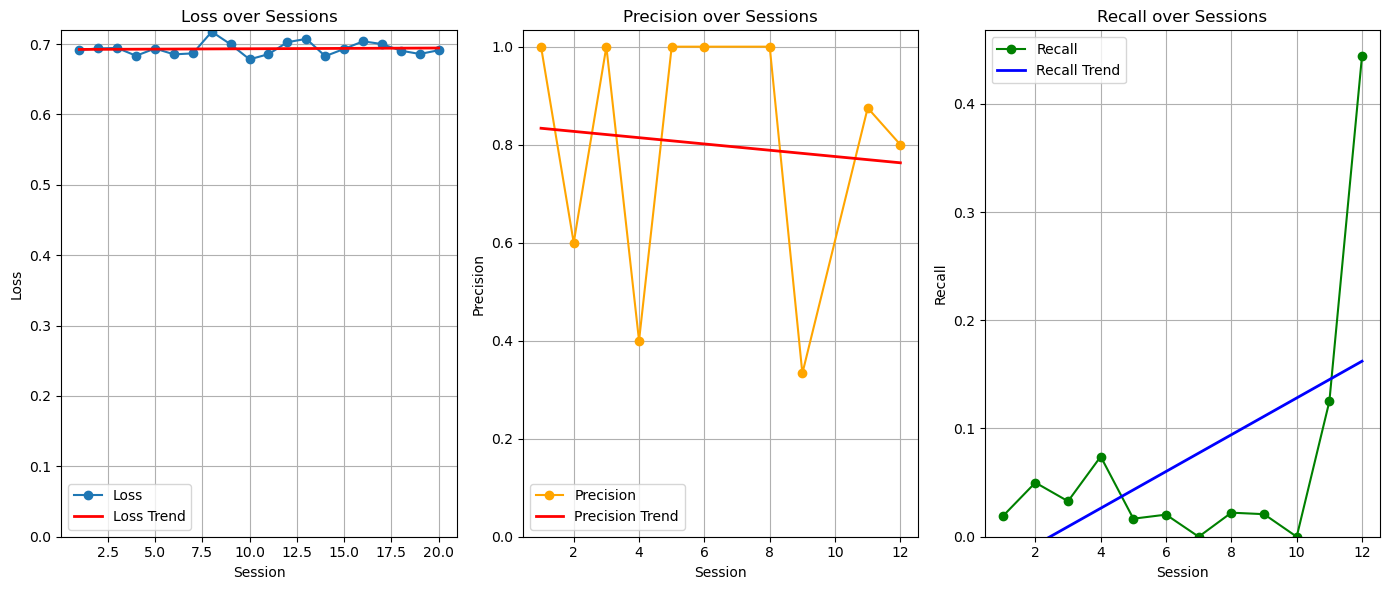

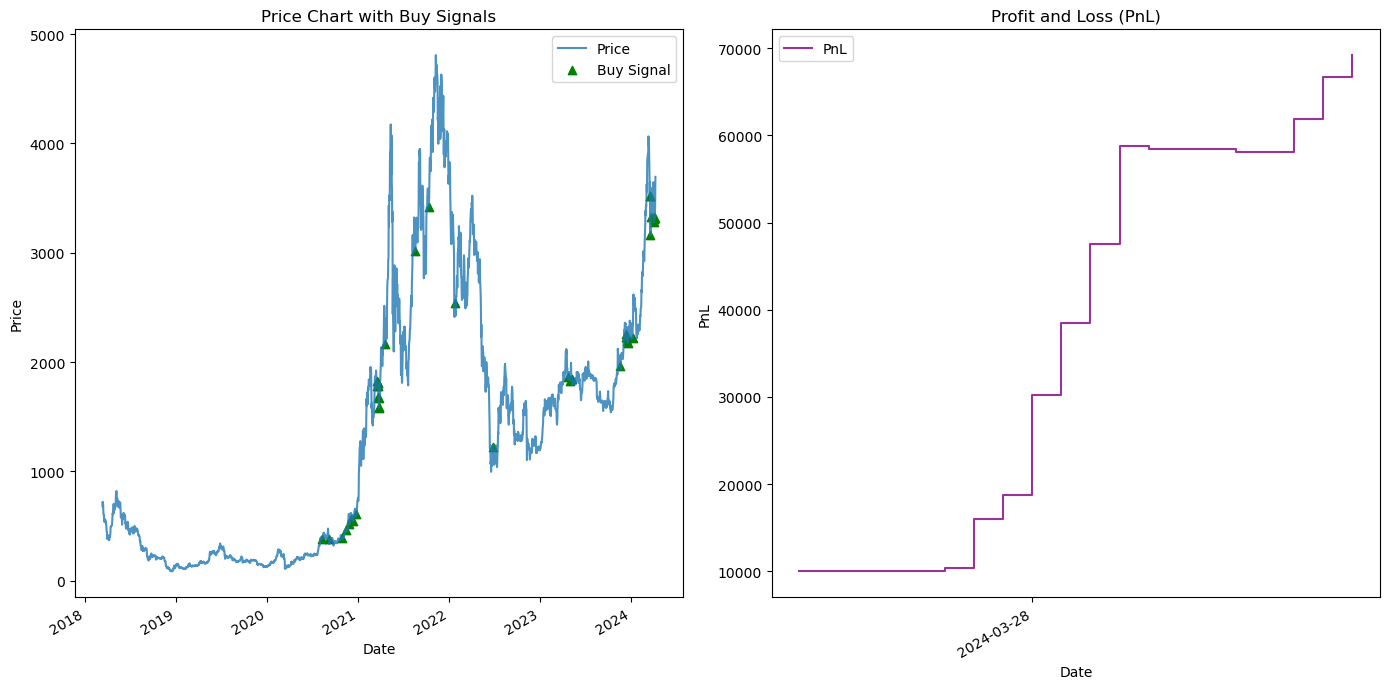

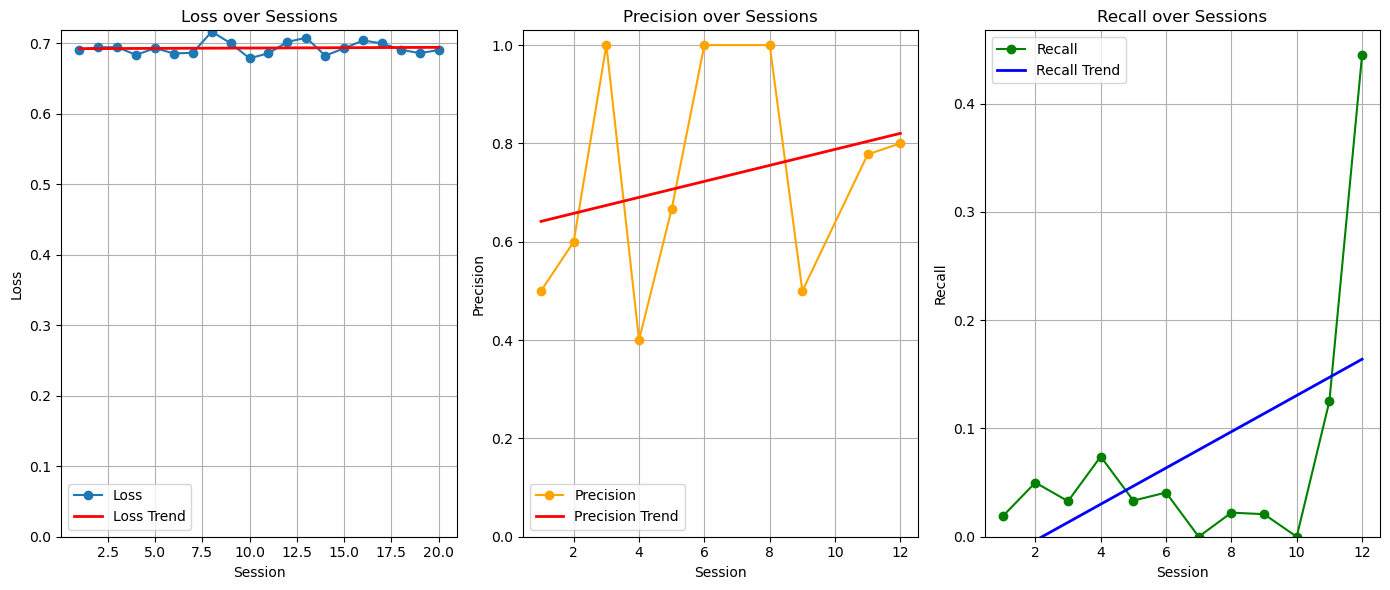

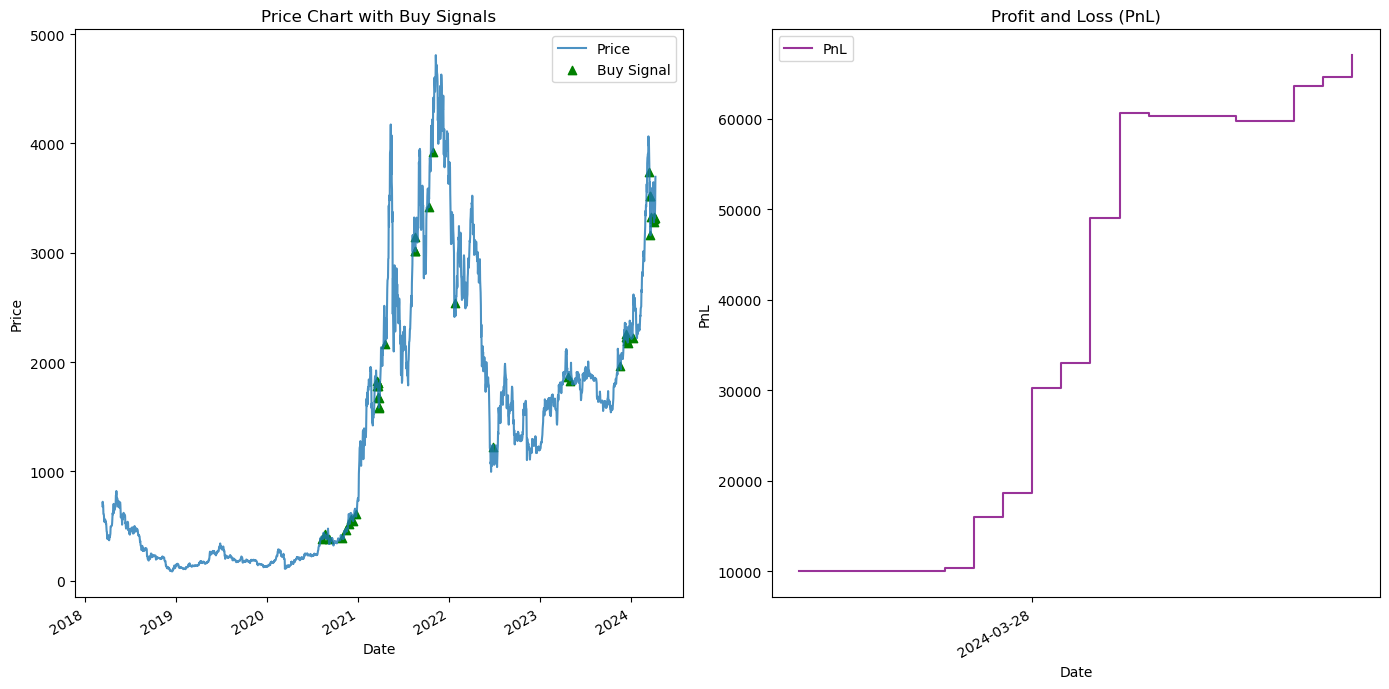

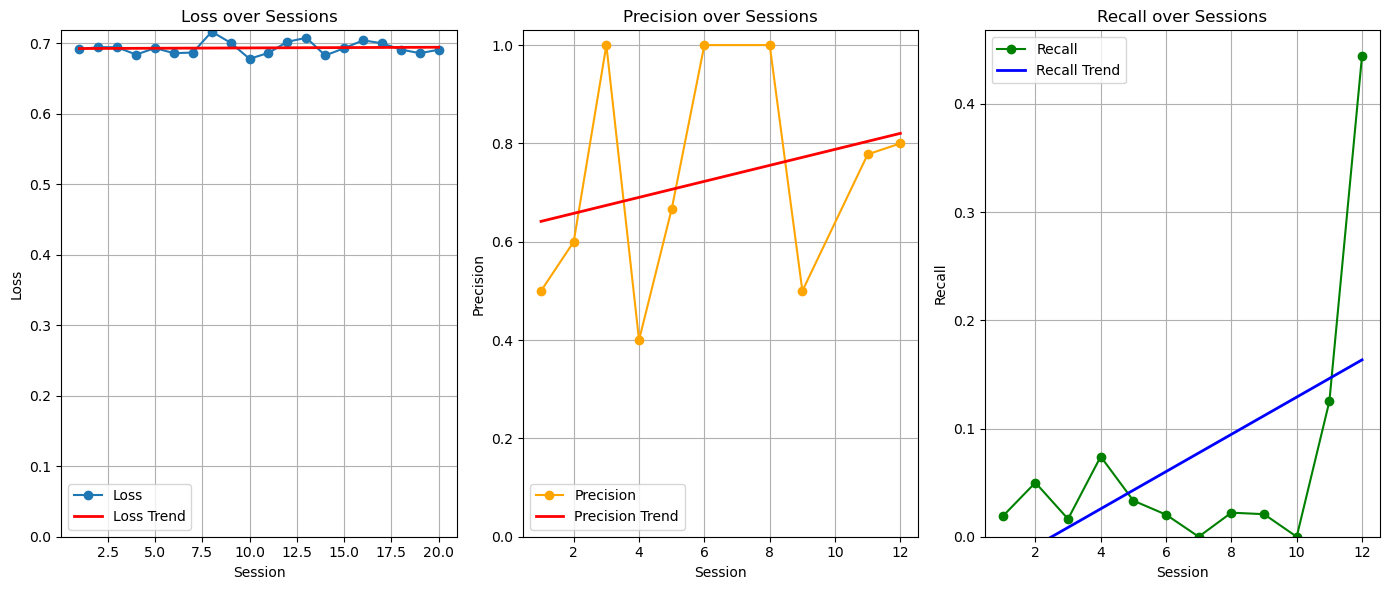

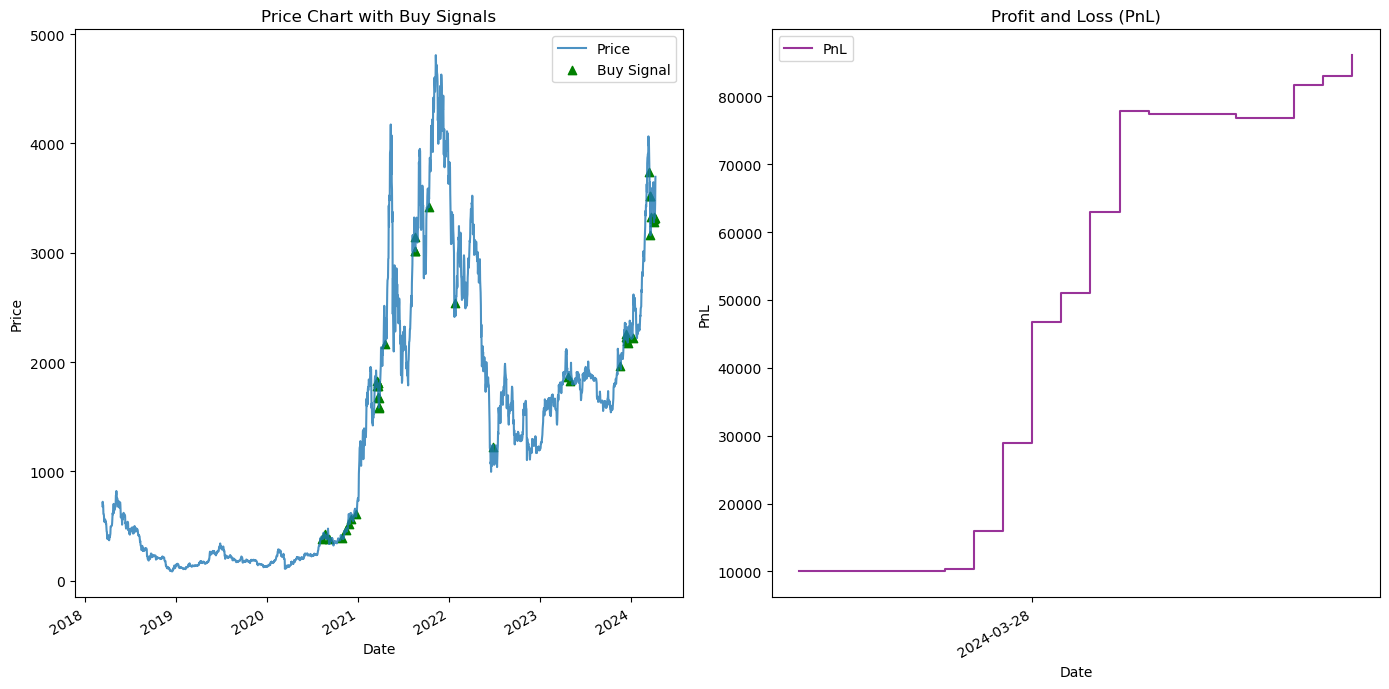

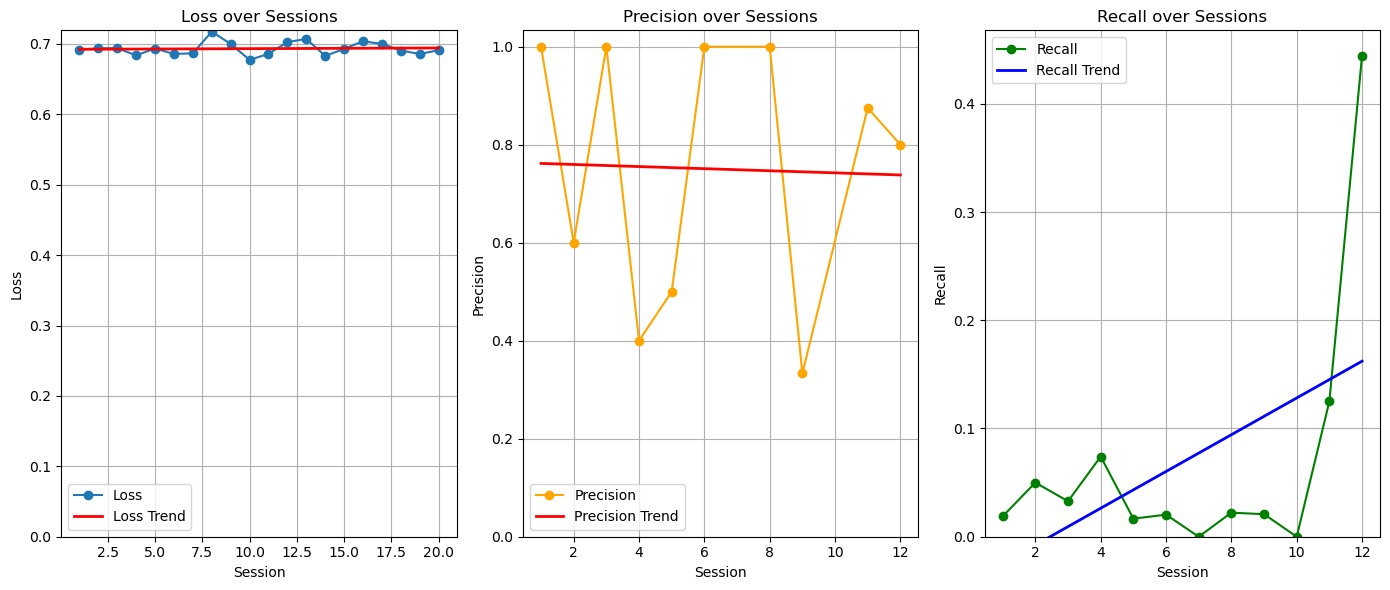

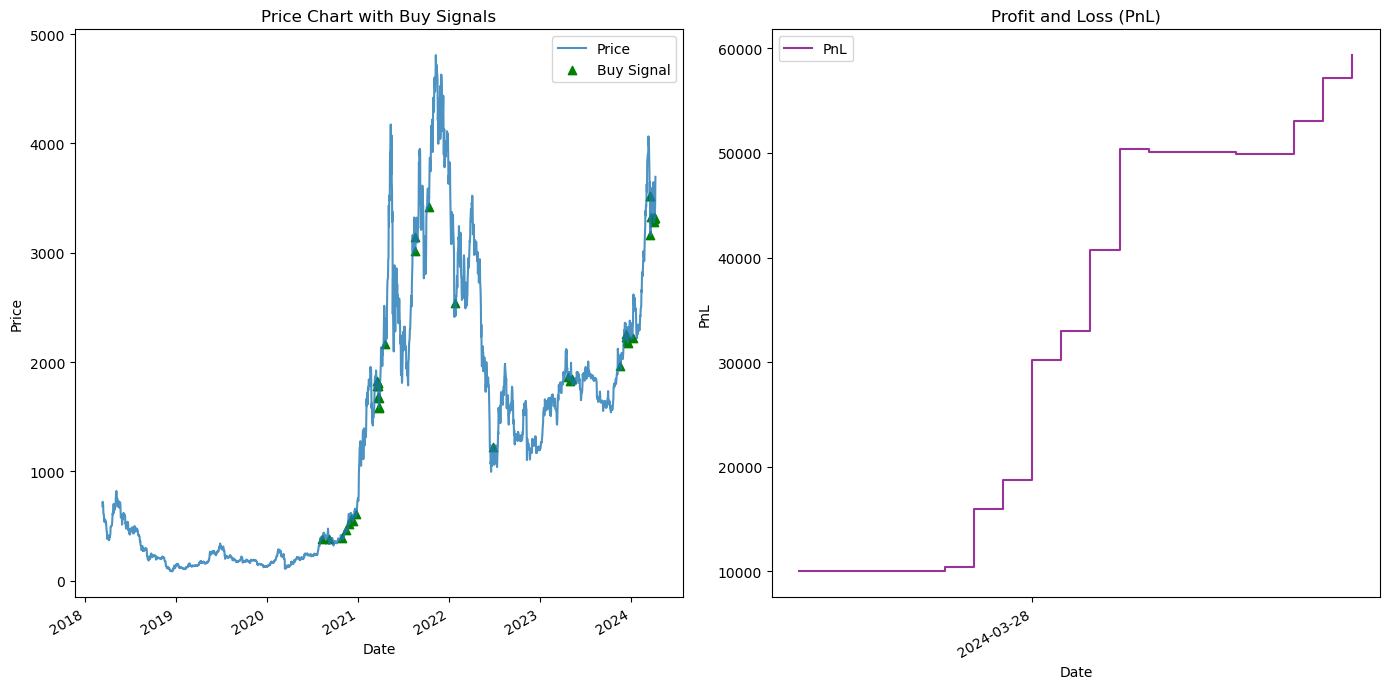

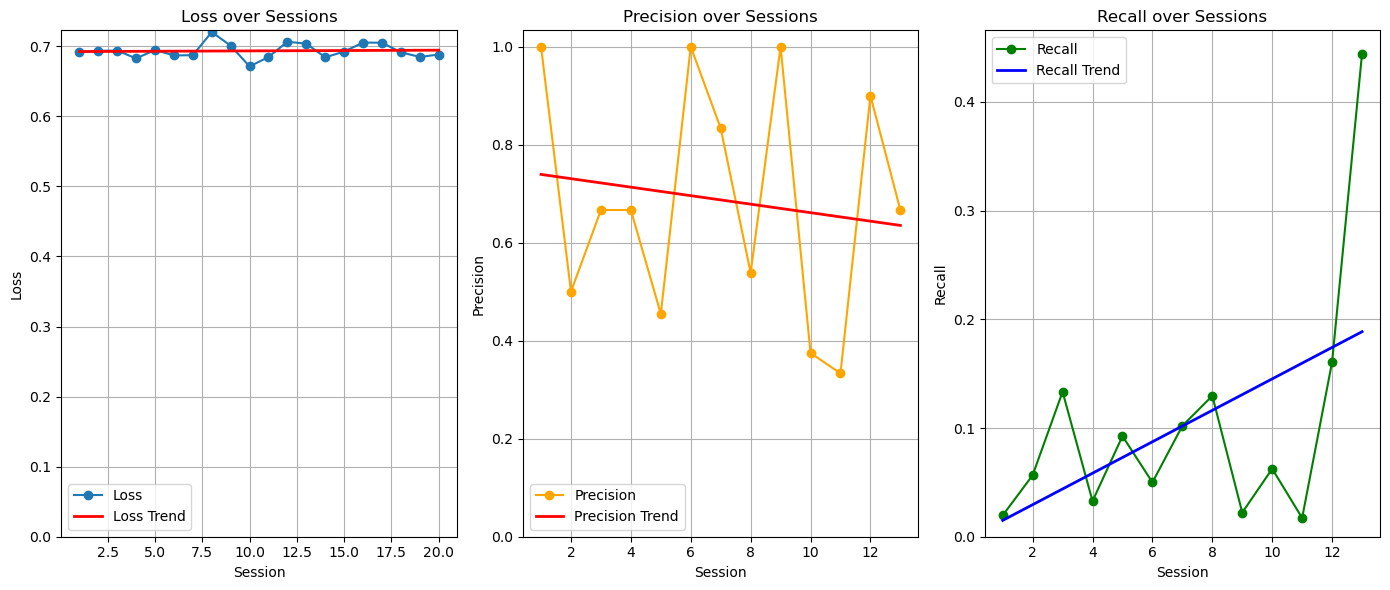

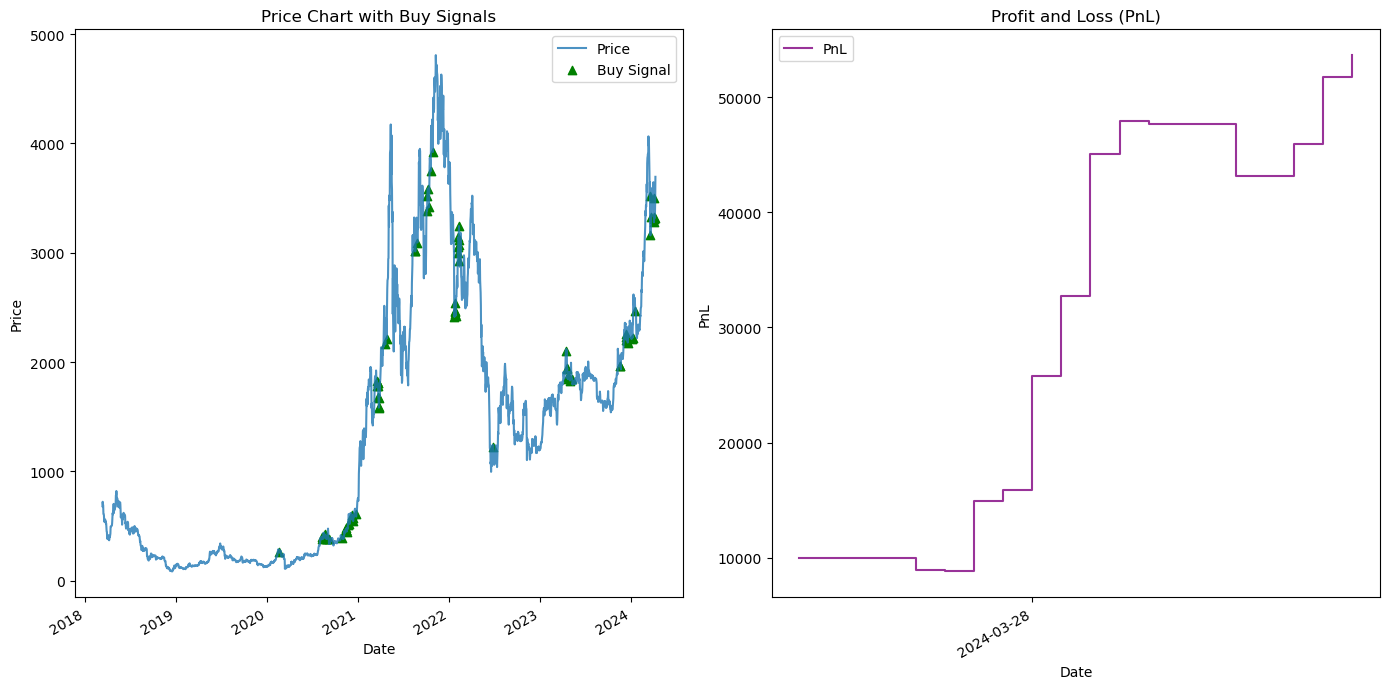

In [17]:
def simulate_trading(df, initial_balance=10000, train_size=300, holding_period=14):
    """
    Simulate trading based on the model's predictions.

    Parameters:
    - df: DataFrame with market data and model's buy signals.
    - initial_balance: Initial capital to start the trading simulation.
    - train_size: The number of initial data points to skip for training.
    - holding_period: The amount of days to hold a position for each buy singal

    Returns:
    - List of daily account balances after simulating trades.
    """

    balance = initial_balance
    holdings = 0
    balances = [balance] * len(df)
    open_positions = []  # To track multiple open positions and their remaining holding time

    # Extract prices and buy signals
    prices = df['close'].values
    buy_signals = df['predictions'].values

    for i in range(train_size, len(df)):
        # Close positions whose holding period is over
        for position in open_positions[:]:  # Iterate over a copy of the list
            if position['holding_time'] <= 0:
                balance += position['holdings'] * prices[i]
                open_positions.remove(position)  # Remove the closed position

        # Update holding time for open positions
        for position in open_positions:
            position['holding_time'] -= 1

        if buy_signals[i] == 1 and balance > 0:
            # Open a new position
            holdings = balance / prices[i]
            balance = 0  # Move balance to holdings
            open_positions.append({'holdings': holdings, 'holding_time': holding_period})

        balances[i] = balance + sum(position['holdings'] * prices[i] for position in open_positions)  # Include value of open positions in balance

    return balances



models = best_sorted_df.head(TOP_MODELS_NUM)['model'].tolist()
test_df = df.dropna()       

for model in models:    
    
    losses, precisions, recalls, preds, pnls = backtest_with_trading_simulation(test_df, model, remaining_features, confidence=0.6)
    print_and_plot_evaluation(losses, precisions, recalls)
    plot_trading_simulation(test_df, preds,  pnls)

#### PnL

As suspected, by extending the holding period for each buy signal to 30 days, we've seen a marked increase in the profit and loss figures. This improvement underscores the importance of precision and adaptability in our model's settings to effectively track market trends. The substantial uplift in profit from such a modest adjustment to our strategy highlights the value of persistent experimentation and flexibility in response to the model's feedback. It's clear that finding the sweet spot in trade settings can have a significant impact on outcomes, proving that sometimes, a small tweak can lead to big wins.


#### Loss, Precision and Recall Scores
Although the Loss and Precision graphs might indicate a declining trend for some models, the stability observed in the loss across all models is encouraging, particularly given the highly unpredictable nature and inherent randomness of the data. With respect to precision, despite some models trending downwards, the average precision remains impressively high for nearly all models, especially after implementing a higher precision threshold (60%). The Recall, showed to be quite stable for all models with a sharp decline towards the end. This indicates that the model have gotten better in spotting the True positives.

# Conclusions

Throughout this project, we delved into the erratic sphere of cryptocurrency trading, aiming to forecast the next-day price fluctuations of Ethereum using the random forest model. This endeavor incorporated various data science and machine learning techniques to train our model. Our journey began with data collection and processing, proceeded to feature gathering and engineering, and addressed feature correlation by discarding highly associated ones. Our initial predictive backtesting system set the stage for early hyperparameter tuning and stopping methods, culminating in a final backtesting system for predictions. The initial results were underwhelming, as the model's performance fell short when compared to the simple buy-and-hold approach. However, a deeper evaluation suggested an intriguing potential: the models exhibited a knack for detecting the beginnings of significant upward trends, indicating a potential for enhanced predictive power with additional refinement.

### Points for Improvement

- Model Complexity: The current model might be too simplistic to capture the complex patterns of cryptocurrency markets. Incorporating more sophisticated models or ensembles could provide a more nuanced understanding of market dynamics.
- Feature Engineering: While we pruned highly correlated features, there’s still room for enhancing the feature set, possibly by adding more diverse market indicators or on-chain data analysis to capture a fuller picture of market sentiment.
explored for a more systematic approach to tuning.
- Trading Strategy: Adjusting the trading strategy based on the model's predictions could potentially increase profitability. For instance, varying the holding period or incorporating stop-loss and take-profit thresholds might capture more gains and mitigate losses.

### Possible Ways to Move Forward

- Deep Learning: Exploring neural networks, which have the capability to understand more complex interrelations and might be apt for the non-linear price data patterns.
- Sentiment Analysis: Enhancing the model with sentiment data from social platforms and news outlets (rater than just fear-and-greed index) could provide a deeper understanding of market sentiment.
- On-Chain Analysis Features: Utilizing Ethereum's public ledger data could offer an additional feature set, bringing in elements not previously considered in the project's feature suite.
- Reinforcement Learning: Implementing reinforcement learning to develop a model that hones its trading strategies through a process of iterative learning in a simulated setting.
- Implementing Trading Strategies: Incorporating trading tactics like stop-loss and take-profit can help manage risk and secure earnings, potentially requiring a precision greater than 33% to ensure profitability.

### Personal Note

I began this project with close to now knoelwdge in machine learning and data science I embarked on this project with minimal knowledge of machine learning and data science, especially in the applied context. Through research and experimentation, I've learned extensively about these fields, including various techniques, models, and methodologies that can be used to develop robust models. The project was a series of trial and error that, in my opinion, led to quite impressive results. Although the model developed here might not be ready to outperform a market as efficient as Ethereum, the coding approach is designed so that the model can be applied to any cryptocurrency. Moreover, it can be expanded upon with additional features and data processing to strengthen its predictive capability. My personal takeaway is that this project serves as an excellent introduction to the world of algorithmic trading, and I am certain that I will pursue similar endeavors in the future or further develop this one.